# Marketing Email Campaign

### Objective 


In this exercise we are given data about an email campaign from a hypothetical e-commerce site.  The site has email addresses from all of the users and have chosen a random sample of them and emailed them.  The email was to let them know about a new feature.

From a marketing perspective, sucess is if the user clicks on the link inside of the email which takes the user to the company site.

We are tasked with figuring out how successful the email campaign was.

Some of the questions needing answers include:
* What percentage of users opened the email and what percentage clicked on the link
within the email?
* Can we build  amodel to optimize in future email campaigns to maximize the probability of users clicking on the link inside of the email? 
    * The VP of marketing thinks that it is stupid to send emails to a random subset and in a random way.
* By how much do you think your model would improve click through rate ( defined as # of users who click on the link / total users who received the email)? 
* How would you test that?
* Did you find any interesting pattern on how the email campaign performed for different segments of users? Explain.



So to repeat, the overall goal is to evaluate whether the email campaign is successful, and then create a model with optimizes and improves the click through rate of future emails.


<u>Data on our emails includes:</u>
* email_id : the Id of the email that was sent. It is unique by email
* email_text : there are two versions of the email: one has "long text" (i.e. has 4 paragraphs) and one has "short text" (just 2 paragraphs)
* email_version : some emails were "personalized" (i.e. they had the name of the user receiving the email in the incipit, such as "Hi John,"), while some emails were "generic" (the incipit was just "Hi,").
* hour : the user local time when the email was sent.
* weekday : the day when the email was sent.
* user_country : the country where the user receiving the email was based. It comes from
* the user ip address when she created the account.
* user_past_purchases : how many items in the past were bought by the user receiving the email

<u> Email open table infomation includes </u>
* email_id : the id of the emails that were opened, i.e. the user clicked on the email and, supposedly, read it

<u>link_clicked_table information includes </u>
* email_id : if the user clicked on the link within the email, then the id of the email shows up on this table

In [563]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from datetime import datetime
import seaborn as sns
import scipy.stats as stats
import itertools
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2,f_classif
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.pipeline import Pipeline
from numpy.random import beta as beta_dist

# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.cross_validation import KFold
from sklearn.grid_search import GridSearchCV

from scipy.stats import skew, skewtest
import lifelines as sa
from lifelines.utils import concordance_index, k_fold_cross_validation

from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, LinearRegression, Perceptron
import datetime
# Importing Machine learning models library used for classification
from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor, BaggingClassifier,GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.naive_bayes import GaussianNB as GB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score,roc_curve, auc
from sklearn import metrics, preprocessing
from sklearn.cross_validation import train_test_split
# import the class
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_selection import f_regression,f_classif
from sklearn import metrics

import matplotlib.patheffects as path_effects
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn import tree
import xgboost as xgb

# import tpot
%config InlineBackend.figure_format = 'png' 
%matplotlib inline
plt.style.use(style='fivethirtyeight')
plt.rcParams['figure.figsize'] = (14, 10)

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-20 09:31:03.553132. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [441]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, \
                          labels = ['Left', 'Stayed']):
    
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, fontsize = 12)
    plt.yticks(tick_marks, labels, rotation = 90, fontsize = 12)
        
    plt.title(title, fontsize = 24)
    plt.ylabel('True', fontsize = 18)
    plt.xlabel('Predicted', fontsize = 18)
    plt.tight_layout()
    
    width, height = cm.shape
    
    for x in range(0,width):
        for y in range(0,height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        color = 'white',
                        fontsize=18).set_path_effects([path_effects.Stroke(linewidth=1, \
                                foreground='black'), path_effects.Normal()])
    return

def add_date_time_columns(dt): 
    
    # ADD THE DATE AND TIME IN SINGLE COLUMNS FOR GROUPPING THE CALLS BY HOURS
    dt1 = np.zeros((dt.shape[0], 4))

    for i in range(0,dt.shape[0]):
        s = dt.timestamp[i]
        s = s.split(' ')
        ymd = s[0]. split('-')
        hms = s[1]. split(':')
        dt1[i,0]=int(ymd[0])
        dt1[i,1]=int(ymd[1])
        dt1[i,2]=int(ymd[2])
        dt1[i,3]=int(hms[0])

    dt1 = pd.DataFrame(dt1)
    dt2 = pd.concat([dt,dt1], axis=1)

    names = dt2.columns.tolist()
    names[names.index(0)] = 'year'
    names[names.index(1)] = 'month'
    names[names.index(2)] = 'day'
    names[names.index(3)] = 'hour'
    dt2.columns = names
    dt2 = pd.DataFrame(dt2)
    
    return dt2

def fixdate(date):
    
    # check the last two characters - the number of seconds - and replace 60 with 59
    if str(date)[-2:] == '60':
        date = date[:-2]+'59'
    
    # check the characters that correspond to minutes and replace 60 with 59
    if str(date)[-5:-3] == '60':
        date = date[:-5]+'59'+date[-3:]
        
    return date

def model_building(dframe,X,y, pred_model):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

    print("Building model %s" %pred_model)
    if pred_model == 'Random Forest':
        modl = RandomForestClassifier(class_weight={0:.978,1:.022})
    elif pred_model == 'SVM Linear':
        modl = SVC(kernel='linear')
    elif pred_model == 'SVM RBF':
        modl = SVC(kernel='rbf')
    elif pred_model == 'Logistic Regression':
        modl = LogisticRegression(class_weight={0:.978,1:.022})
    elif pred_model == 'kNN':
        ref_score = -99
        nbr_neighbors = -9
        for k in range(2,10):
            print("In loop for %s neighbors" %k)
            modl = KNeighborsClassifier(n_neighbors=k)
            modl.fit(X_train, y_train)
            modl.predict(X_test)
            if modl.score(X_test, y_test) > ref_score:
                ref_score = modl.score(X_test, y_test)
                nbr_neighbors = k

        modl = KNeighborsClassifier(n_neighbors=nbr_neighbors)
        print("%s is the optimal number of neighbors" %nbr_neighbors)

    modl.fit(X_train, y_train)
    y_pred = modl.predict(X_test) 

    if pred_model == 'Random Forest':
        labels = list(dframe.columns.values)
#         labels.remove('clicked')
        feat_importance = pd.DataFrame(modl.feature_importances_, columns=['values'])
        feat_importance['index'] = labels
        feat_importance = feat_importance.set_index('index')
        feat_importance = feat_importance.sort_values(['values'], ascending=False)
        print("Features importance: %s" %feat_importance)

    print("Accuracy for %s = %s" %(pred_model, round(100.*modl.score(X_test, y_test), 2)))
    print confusion_matrix(y_test, y_pred)
    
    ####
    logit = y_pred
    y_pred_prob = modl.predict_proba(X_test)[:, 1]
    plt.hist(y_pred_prob, bins=5)
    plt.xlim(0, 1)
    plt.title('Histogram of Predicted Probabilities')
    plt.xlabel('Predicted Probability of Conversion')
    plt.ylabel('Frequency')
    cm = confusion_matrix(y_test, logit)


    plot_confusion_matrix(cm, title='Model: Confusion Matrix', \
                          labels=['Not Converted', 'Converted'], cmap=plt.cm.Greens) 
    # Roc_curve for Logistic Regression Model
    FPR = dict()
    TPR = dict()
    ROC_AUC = dict()

    # For class 1, find the area under the curve
    FPR[1], TPR[1], _ = roc_curve(y_test, logit)
    ROC_AUC[1] = auc(FPR[1], TPR[1])

    # Plot of a ROC curve for class 1
    plt.figure(figsize=[5,5])
    plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0, 1])
    plt.ylim([0, 1.5])
    plt.xlabel('False Positive Rate', fontsize=10)
    plt.ylabel('True Positive Rate', fontsize=10)
    plt.title('Model Receiver operating characteristic for Conversion', fontsize=18)
    plt.legend(loc="upper left")
    plt.show()
    

### Load Data

In [223]:
df_email = pd.read_csv('../data/email_table.csv')
df_link = pd.read_csv('../data/link_clicked_table.csv')
df_open = pd.read_csv('../data/email_opened_table.csv')

In [224]:
df_open['opened'] = 1
df_link['clicked'] = 1
# df_email['received'] = 1
# df_email["response"] = "received"
# df_email.set_index('email_id').loc[df_open.email_id,"response"] = "opened"
# df_email.set_index('email_id').loc[df_link.email_id,"response"] = "clicked"

In [225]:
df = pd.merge(df_email, df_open, how='left', on=['email_id'])
df2 = pd.merge(df, df_link, how='left', on=['email_id'])

In [226]:
df = df2

In [227]:
df.opened = df.opened.fillna(0)
df.clicked = df.clicked.fillna(0)

In [228]:
# Set a default value
df['response'] = 'received'
# Set received value for all row indexes which opened is 1
df['response'][df['opened'] == 1] = 'opened'
# Set received value for all row indexes which clicked is 1
df['response'][df['clicked'] == 1] = 'clicked'


/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### What percentage of users opened the email and what percentage clicked on the link within the email?

In [236]:
print "Open Rate: ",round(df['opened'].sum()*100/len(df),2), "%"
print "Click Rate: ",round(df['clicked'].sum()*100/len(df),2), "%"
print "Click-Through Rate: ", round(df['clicked'].sum()*100/df['opened'].sum(),2), "%"

Open Rate:  10.35 %
Click Rate:  2.12 %
Click-Through Rate:  20.48 %


In [230]:
df['time'] = np.where((df['hour'] == 6) & (df['hour'] <= 12), 'Morning'
                      , np.where((df.hour > 12) & (df.hour < 18),'Afternoon'
                                 , np.where((df.hour >= 18) & (df.hour <= 24), 'Night', 'Early Morning'))
                     )
df['prior_purchases'] = np.where(df['user_past_purchases'] == 0, '0 prior purchase'
                                 ,np.where(df['user_past_purchases'].isin([1, 2]), '1-2 prior'
                                           ,np.where(df.user_past_purchases.isin([3, 4, 5, 6])
                                                     , '3-6 prior', '6+ prior')))

df['purchases_cat'] = np.where(df['user_past_purchases'] > 0, '1+ purchases','0 purchases' )
df['purchases_flag'] = np.where(df['user_past_purchases'] > 0, 1,0 )


# df['country']=np.where(df.user_country.isin(['US','UK']),'US_UK','FR_ES')


df['day_type']=np.where(df.weekday.isin(['Saturday','Sunday']),'Weekend','Weekday')

df["paragraphs"] = np.where(df.email_text == 'short_email',2,4)

df["is_personal"] = (df.email_version == "personalized").astype(np.int)

weekday2index = {"Monday":1,"Tuesday":2,"Wednesday":3,"Thursday":4,"Friday":5,"Saturday":6,"Sunday":7}
df["weekday_index"] = df.weekday.map(weekday2index)

# df['received'] = np.where((df['opened'] == 0) & (df['clicked'] == 0), 1,0 )
# df['received'] = 1
# rename long column names to shorter names, make it easier to read
df.rename(columns={'user_past_purchases':'purchases','user_country':'country'},inplace=True)


In [341]:
df.describe()

,email_id,hour,purchases,opened,clicked,purchases_flag,paragraphs,is_personal,weekday_index
count,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000
mean,498690.196160,9.059300,3.87845,0.103450,0.021190,0.861230,3.00552,0.497910,4.010170
std,289230.727534,4.439637,3.19611,0.304547,0.144018,0.345708,0.99999,0.499998,2.004626
min,8.000000,1.000000,0.00000,0.000000,0.000000,0.000000,2.00000,0.000000,1.000000
25%,246708.250000,6.000000,1.00000,0.000000,0.000000,1.000000,2.00000,0.000000,2.000000
50%,498447.000000,9.000000,3.00000,0.000000,0.000000,1.000000,4.00000,0.000000,4.000000
75%,749942.750000,12.000000,6.00000,0.000000,0.000000,1.000000,4.00000,1.000000,6.000000
max,999998.000000,24.000000,22.00000,1.000000,1.000000,1.000000,4.00000,1.000000,7.000000


Notes

Our outliers:

* Purchases above 9


Let's see if that matters link click probability, if so we'll leave the outliers in, if not we'll remove them

In [343]:
df['purchase_outlier'] = np.where(df.purchases > 9, True, False)

In [344]:
purchase_conv = pd.crosstab(df['purchase_outlier'],df['clicked'])
purchase_conv['convprc'] = purchase_conv[1]/(1.0*purchase_conv[0]+purchase_conv[1])
purchase_conv

clicked,0.0,1.0,convprc
purchase_outlier,,,
False,92041,1743,0.018585
True,5840,376,0.060489


conversion is a little below 2% for those that have less than or equal to 9 prior purchases and 6% for those that have more than 9 prior purchases

In [345]:
# Let's test for independence of these two variables using a chi-squared test
from scipy.stats import chi2_contingency
chi2_contingency((pd.crosstab(df['purchase_outlier'],df['clicked'])), correction=False)[1]  

2.42560675620965e-109

Great so the p-value signals that users with or without the threshold of prior purchases do not convert at the same rate.

So let's leave them in

In [217]:
categorical_vars = ['email_text','email_version','weekday','day_type']
categorical_vars2 = ['prior_purchases','purchases_cat','country','time']

In [218]:
def plot_variables(variable_list = categorical_vars, file_location='../figures/categorical_vars.png'):
    for i,j in itertools.izip_longest(variable_list,range(len(variable_list))): # itertools.zip_longest for to execute the longest loop
        plt.subplot(np.ceil(len(variable_list)/2),2,j+1)
        plt.subplots_adjust(hspace=.5)
        sns.countplot(x=i,data = df)
        plt.xticks(rotation=45)
        plt.title(str("No. of Emails by "+i.title()))
        # Get current axis on current figure
        ax = plt.gca()

        # Iterate through the list of axes' patches
        for p in ax.patches:
            ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
                    fontsize=12, color='black', ha='center', va='bottom')
    plt.savefig(file_location)

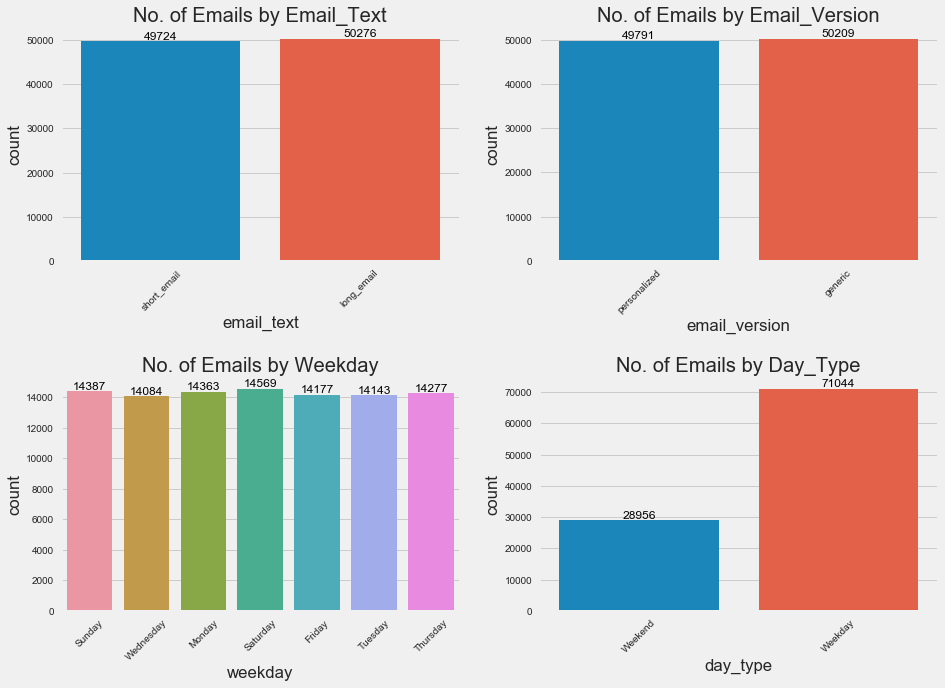

In [219]:
plot_variables(variable_list = categorical_vars, file_location='../figures/categorical_vars.png')

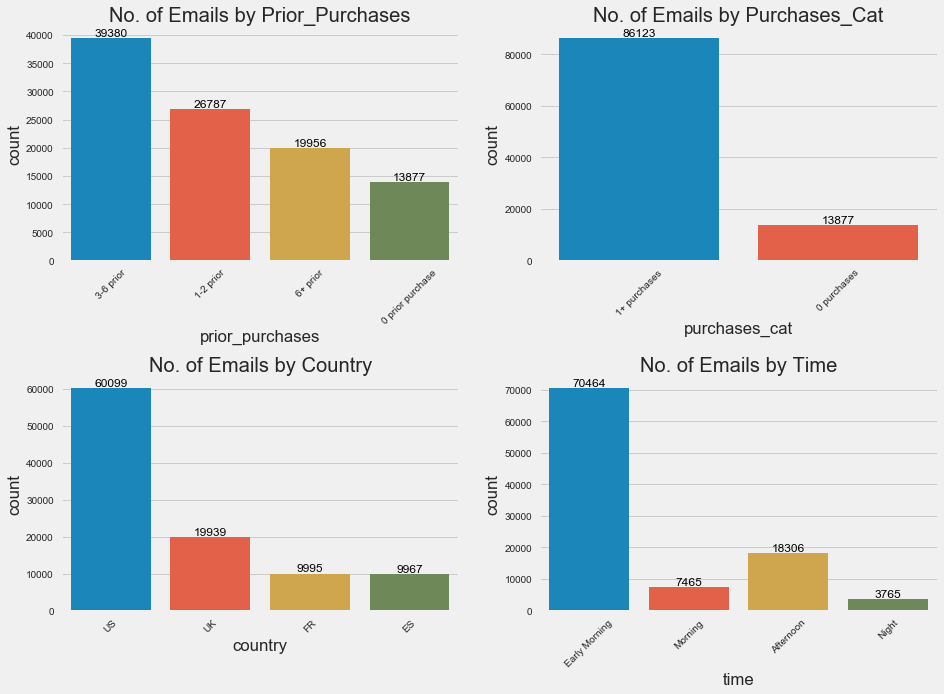

In [220]:
plot_variables(variable_list = categorical_vars2, file_location='../figures/categorical_vars2.png')

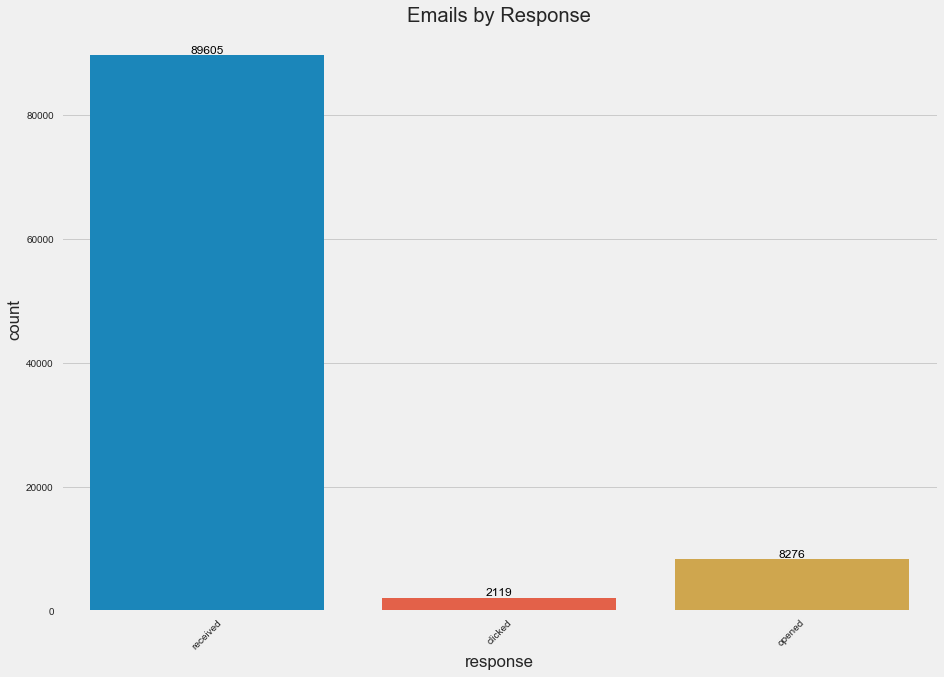

In [235]:
sns.countplot(x='response',data = df)
plt.xticks(rotation=45)
plt.title(str("Emails by Response"))
# Get current axis on current figure
ax = plt.gca()

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')
plt.savefig('../figures/emails_by_response.png')

Notes:
  * We've got a US based site in which many of the users in the email list have purchased items before.
  * Also many of the emails were opened in the early morning during a week day


In [584]:
def count_result_ratio(df):
    counts = df.response.value_counts(normalize=True)
    counts['total'] = df.shape[0]
    return counts

def ct_rate(df):
    counts = df[df.opened == 1].response.value_counts(normalize=True)
    counts['total'] = df.shape[0]
    return counts

def grp_count_opens_plotbar(key):
    grpresult = df.groupby(key).apply(count_result_ratio)
    # grpresult.loc[:,["received","opened",'clicked']].plot(kind='bar')
    grpresult.loc[:,['clicked']].plot(kind='bar',title='Click Ratio vs. {}'.format(key))
        # Get current axis on current figure
    ax = plt.gca()

    # Iterate through the list of axes' patches
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%r' % round(float(p.get_height()),2), 
                fontsize=12, color='black', ha='center', va='bottom')
    plt.ylabel('Click Ratio')
    plt.savefig('../figures/click_ratio_by_'+var+'.png')
    return grpresult

def grp_count_plotbar(key):
    grpresult = df.groupby(key).apply(ct_rate)
    # grpresult.loc[:,["received","opened",'clicked']].plot(kind='bar')
    grpresult.loc[:,['clicked']].plot(kind='bar',title='Click Through Rate vs. {}'.format(key))
        # Get current axis on current figure
    ax = plt.gca()

    # Iterate through the list of axes' patches
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%r' % round(float(p.get_height()),2), 
                fontsize=12, color='black', ha='center', va='bottom')
    plt.ylabel('Click Through Rate')
    plt.savefig('../figures/CTR_'+var+'.png')
    return grpresult

def grp_count_open_plotbar(key):
    grpresult = df.groupby(key).apply(count_result_ratio)
    # grpresult.loc[:,["received","opened",'clicked']].plot(kind='bar')
    grpresult.loc[:,['opened']].plot(kind='bar',title='Open Rate vs. {}'.format(key))
        # Get current axis on current figure
    ax = plt.gca()

    # Iterate through the list of axes' patches
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%r' % round(float(p.get_height()),2), 
                fontsize=12, color='black', ha='center', va='bottom')
    plt.ylabel('Open Ratio')
    plt.savefig('../figures/open_rate_by_'+var+'.png')
    return grpresult

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-20 21:26:04.353796. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [262]:
rslt_grpby_purchase = df.groupby("purchases").apply(count_result_ratio).unstack()
rslt_grpby_purchase.fillna(value=0,inplace=True)

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-20 21:25:18.793119. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


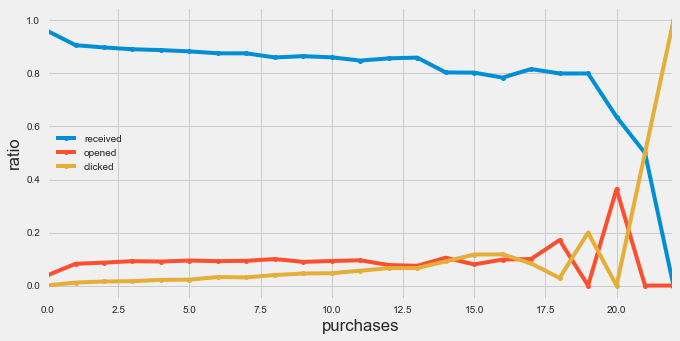

In [583]:
plt.rc('figure', figsize=(10, 5))
rslt_grpby_purchase.loc[:,["received","opened",'clicked']].plot(marker='o',markersize=5)
plt.ylabel("ratio")
plt.savefig('../figures/response_likelihood_by_purchases.png')

It looks like purchases doesn't matter much in terms of probability to open or click until you get to the extremes. Once you hit 17 purchases it starts to matter, but then you see that the received ratio drops off at around 17 meaning there aren't many instances where users have made that many purchases. Therefore the effect is greater

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-20 21:26:07.944984. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


response,received,opened,clicked,total
hour,,,,
1,0.910840,0.071032,0.018128,2703.0
2,0.911589,0.072089,0.016322,3676.0
3,0.915184,0.065293,0.019523,4610.0
4,0.911419,0.072394,0.016186,5622.0
5,0.917417,0.064570,0.018013,6551.0
6,0.909176,0.073677,0.017147,7465.0
7,0.909434,0.072282,0.018284,8204.0
8,0.911407,0.069659,0.018933,8398.0
9,0.873725,0.100481,0.025794,8529.0


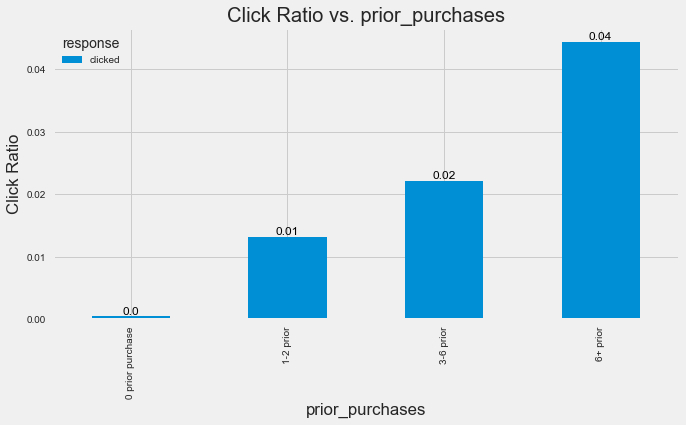

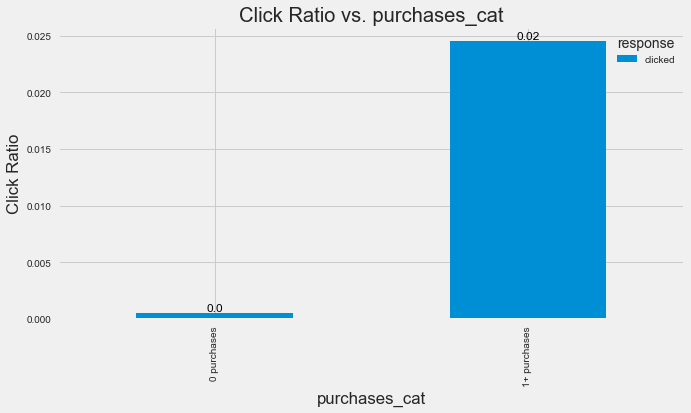

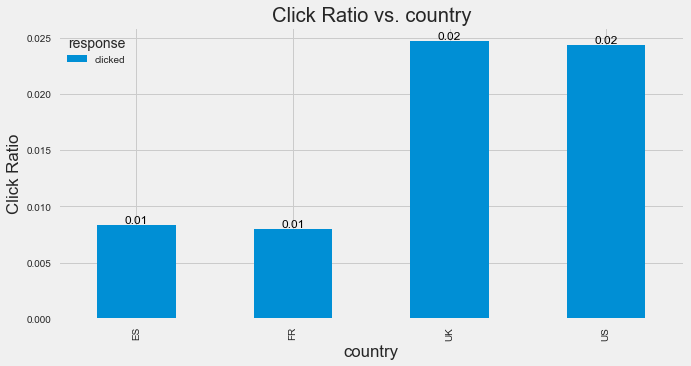

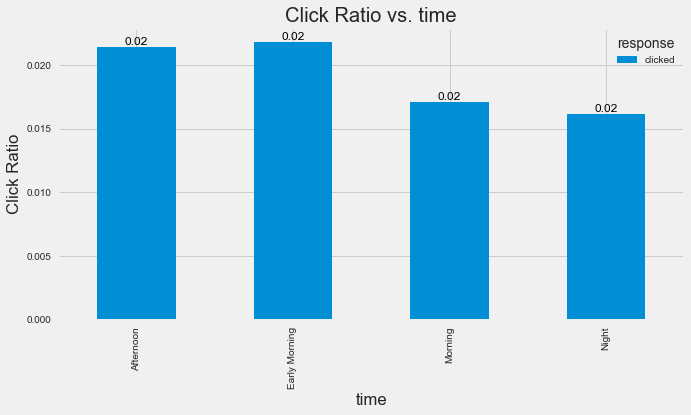

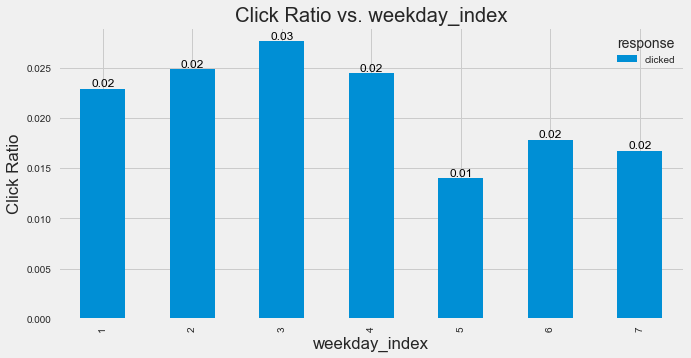

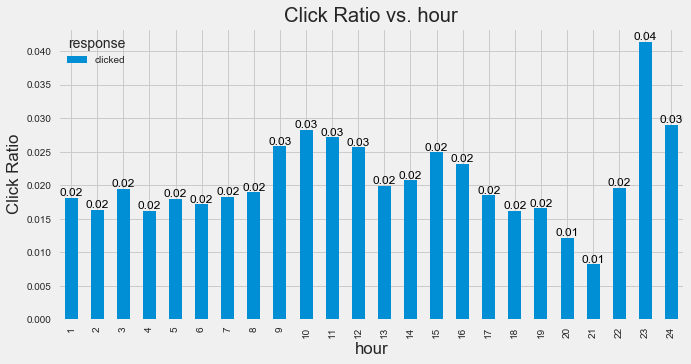

In [585]:
for i in (categorical_vars and categorical_vars2):
    grp_count_opens_plotbar(i)
grp_count_opens_plotbar('weekday_index')

grp_count_opens_plotbar('hour')

Notes
* Those with many purchases tend to click more email links
    * Makes sense as the sense of loyalty increases with each purchase and the product becomes stickier
* Those with 0 purchases basically never click the email inks
* The UL and US userbase click the email links at a much higher rate than Spain and France
* Mid day hours seem to be the best time to send an email if you want the link clicked, although the categories don't vary too greatly in terms of click ratio
* Send an email during the week if you want to optimize for click ratio as the best day is Wednesday with a .03 ratio and the worst day is Friday with the other worst days being Sat and Sun
* Since more people click in the morning, and as we'll see CTR remains fairly evenly distributed, a suggestion would be to optimize for clicks

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-20 21:26:17.830167. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


response,opened,clicked,total
hour,,,
1,0.803347,0.196653,2703.0
2,0.820433,0.179567,3676.0
3,0.771795,0.228205,4610.0
4,0.820565,0.179435,5622.0
5,0.786245,0.213755,6551.0
6,0.816024,0.183976,7465.0
7,0.802436,0.197564,8204.0
8,0.787349,0.212651,8398.0
9,0.799440,0.200560,8529.0


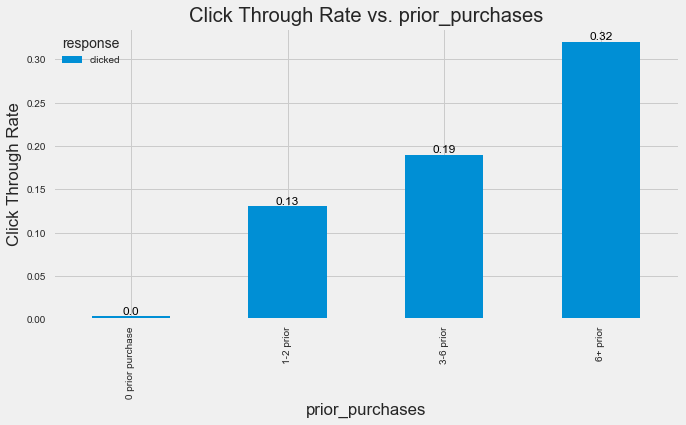

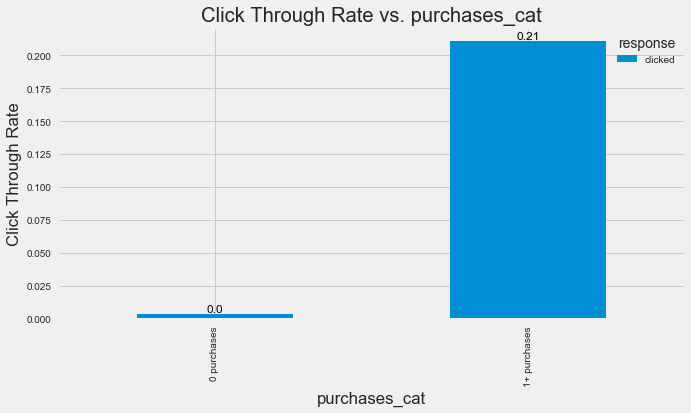

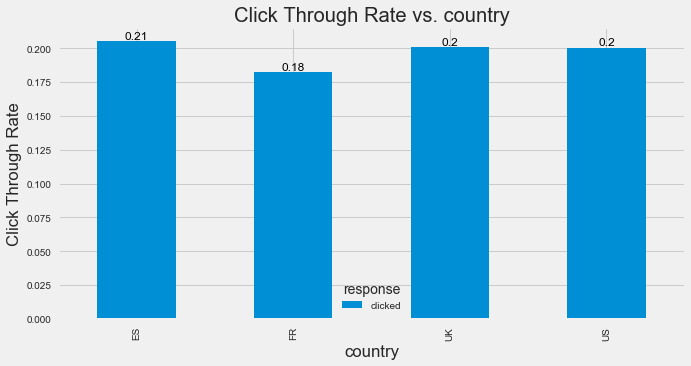

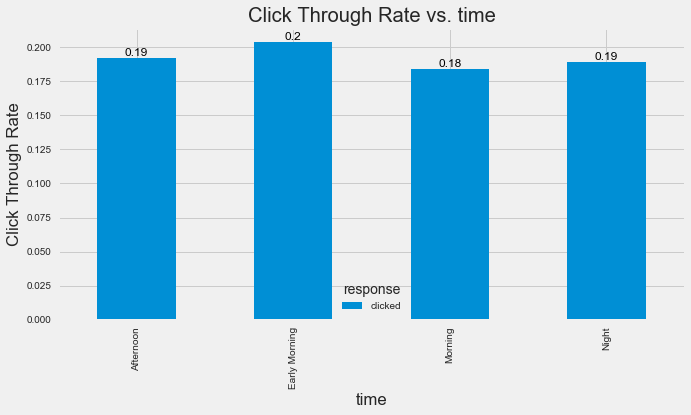

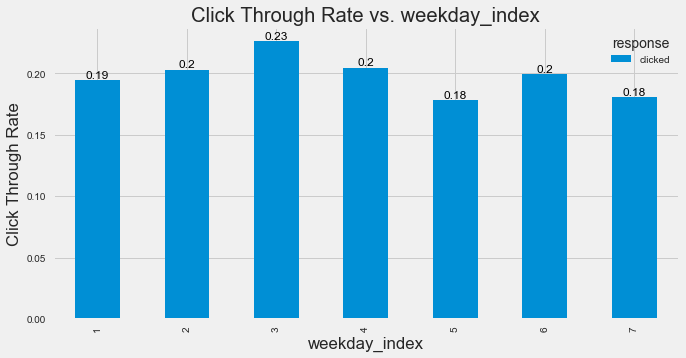

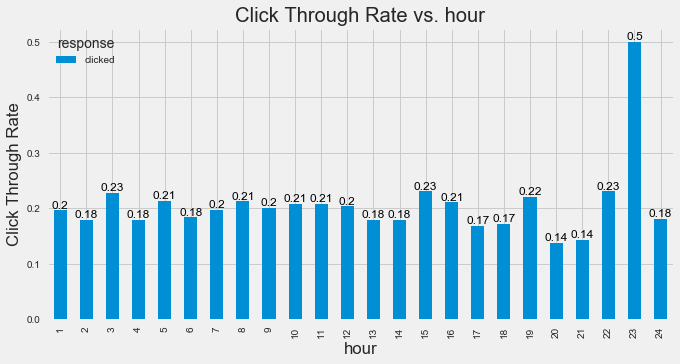

In [586]:
for i in (categorical_vars and categorical_vars2):
    grp_count_plotbar(i)
    
grp_count_plotbar('weekday_index')

grp_count_plotbar('hour')

Notes
* Click through rate seems to be the same regardless of email length
* Personalized emails have a higher click through rate than generic emails
* Wednesday has the highest click through rate, which is aligned with what we've seen for click ratio

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-20 21:26:20.038435. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


response,received,opened,clicked,total
hour,,,,
1,0.910840,0.071032,0.018128,2703.0
2,0.911589,0.072089,0.016322,3676.0
3,0.915184,0.065293,0.019523,4610.0
4,0.911419,0.072394,0.016186,5622.0
5,0.917417,0.064570,0.018013,6551.0
6,0.909176,0.073677,0.017147,7465.0
7,0.909434,0.072282,0.018284,8204.0
8,0.911407,0.069659,0.018933,8398.0
9,0.873725,0.100481,0.025794,8529.0


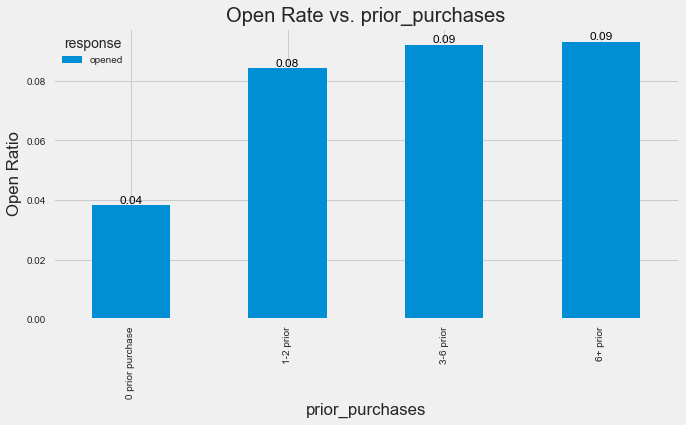

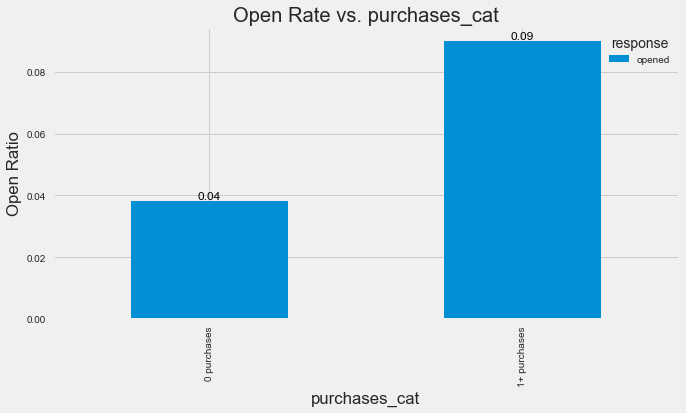

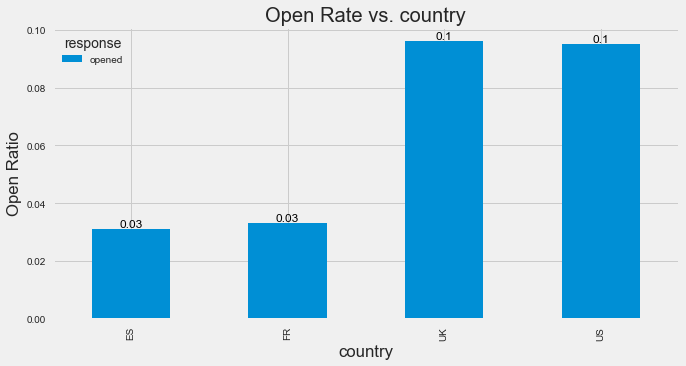

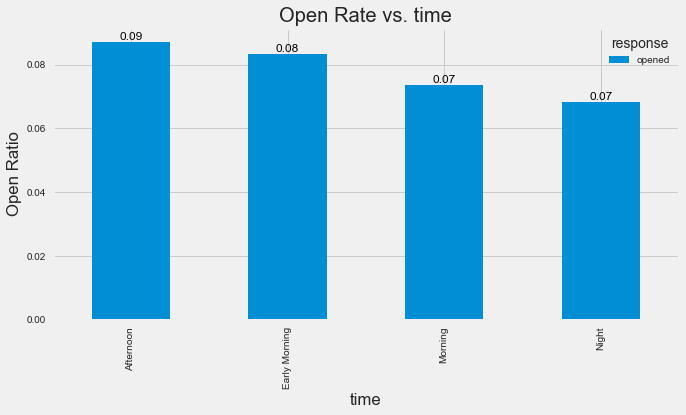

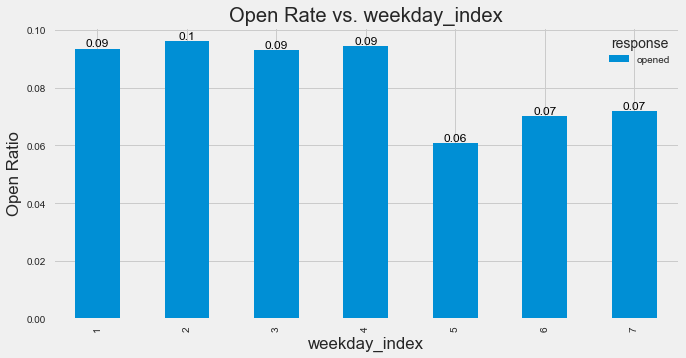

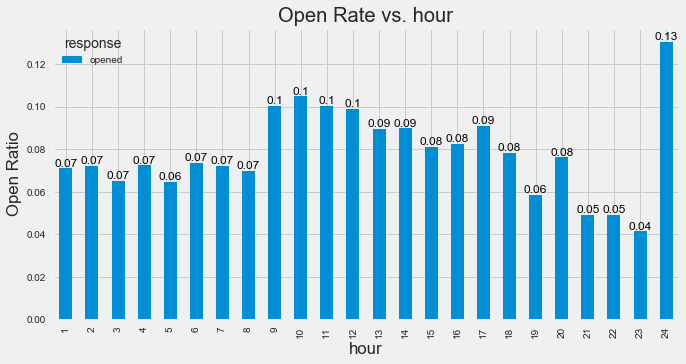

In [587]:
for i in (categorical_vars and categorical_vars2):    
    grp_count_open_plotbar(i)

grp_count_open_plotbar('weekday_index')
grp_count_open_plotbar('hour')

Notes:
* If you want your email opened, send a short email as if fairs better in terms of open rate. However it's a .02 difference so that might not matter for all businesses
* Personalize your emails if you want them opened
* Send emails on Tuesday or more generally during the week if you want it opened
    

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-20 21:26:42.649558. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


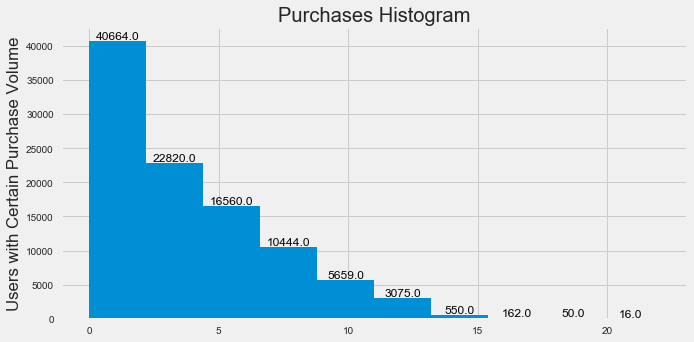

In [588]:
df.purchases.hist()
ax = plt.gca()
plt.title('Purchases Histogram')
# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%r' % round(float(p.get_height()),2), 
            fontsize=12, color='black', ha='center', va='bottom')
plt.ylabel('Users with Certain Purchase Volume')
plt.savefig('../figures/purchases_histogram.png')

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-20 21:27:01.321357. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


9     8529
8     8398
7     8204
10    8180
11    7483
6     7465
5     6551
12    6508
4     5622
13    5581
3     4610
14    4580
2     3676
15    3493
16    2759
1     2703
17    1893
18    1421
19     905
20     656
21     365
22     204
23     145
24      69
Name: hour, dtype: int64

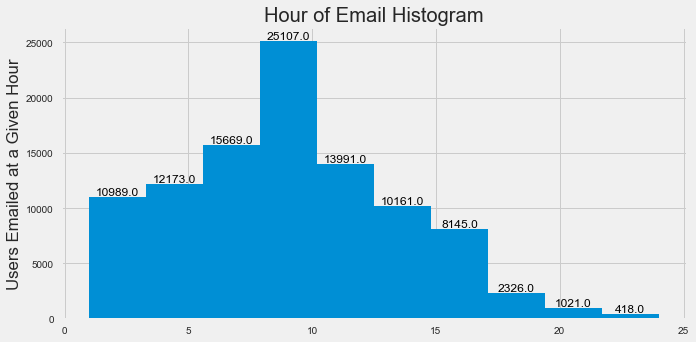

In [589]:
df.hour.hist()
ax = plt.gca()
plt.title('Hour of Email Histogram')
# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%r' % round(float(p.get_height()),2), 
            fontsize=12, color='black', ha='center', va='bottom')
plt.ylabel('Users Emailed at a Given Hour')
plt.savefig('../figures/hour_histogram.png')
df.hour.value_counts()

Notes

While the volume of emails peak at 9, the open rate and click through rate peaks a bit later at 11.  We would like to see those match up, although maybe the service provider is that slow and it takes 2 hours to deliver the email. Very unlikely but I've been in the situation where queues get backed up and emails take a while to send

In [338]:
set(df)

{'clicked',
 'country',
 'day_type',
 'email_id',
 'email_text',
 'email_version',
 'hour',
 'is_personal',
 'opened',
 'paragraphs',
 'prior_purchases',
 'purchases',
 'purchases_cat',
 'purchases_flag',
 'response',
 'time',
 'weekday',
 'weekday_index'}

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-20 21:27:18.376074. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


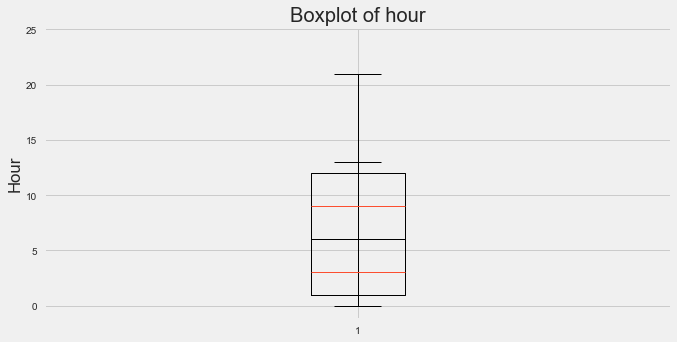

In [590]:
for i in ['purchases', 'hour']:
    ax = plt.gca()
    plt.title('Boxplot of {}'.format(i))
    
    plt.boxplot(df[i])
    # Iterate through the list of axes' patches
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%r' % round(float(p.get_height()),2), 
                fontsize=12, color='black', ha='center', va='bottom')
    plt.ylabel('Hour')
    plt.savefig('../figures/hour_boxplot.png')

In [321]:
def day_hour_heatmap(df, metric, email_type,file_location='../figures/'):
    out_dir_plot =  file_location
    dframe = df.copy()
    if email_type:
        subset = dframe[dframe[email_type[0]] == email_type[1]]
    else:
        subset = dframe.copy()

    # Percentage wrt all emails sent out
    # grouped = 100. * subset.groupby(['weekday', 'hour'])[metric].count().unstack() / subset.shape[0]

    # Percentage wrt all emails sent out on a given day
    grouped = subset.groupby(['weekday', 'hour'])[metric].count().unstack()
    grouped = grouped.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    # At this point, rows = days (sorted as in the week), columns = hours, and values = % wrt overall emails count

    grouped_perc = grouped.apply(lambda x: x / x.sum() * 100, axis=1)
    grouped_perc = grouped_perc.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

    # Conversion of the data frames into a matrices for heatmap representation
    matr = grouped_perc.as_matrix().transpose()

#     if not os.path.exists(out_dir_plot + metric + '_' + email_type[1] + '_per_weekday_hour_heatmap.png'):
    fig = plt.figure(10)
    ax = fig.add_subplot(111)
    im = ax.imshow(matr, cmap='hot_r', interpolation='nearest')
    ax.set_xlabel('xlabel')
    ax.set_aspect(0.35)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax, label='Percentage (%)')
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
    ax.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
    ax.set_ylabel('Hours')
    ax.set_xlabel('')
    fig.suptitle('Weekday vs. hour ' + metric + ' heatmap for ' + email_type[1], fontsize=15)
    plt.show()
    fig.savefig(out_dir_plot + metric + '_' + email_type[1] + '_per_weekday_hour_heatmap.png')
    plt.close()

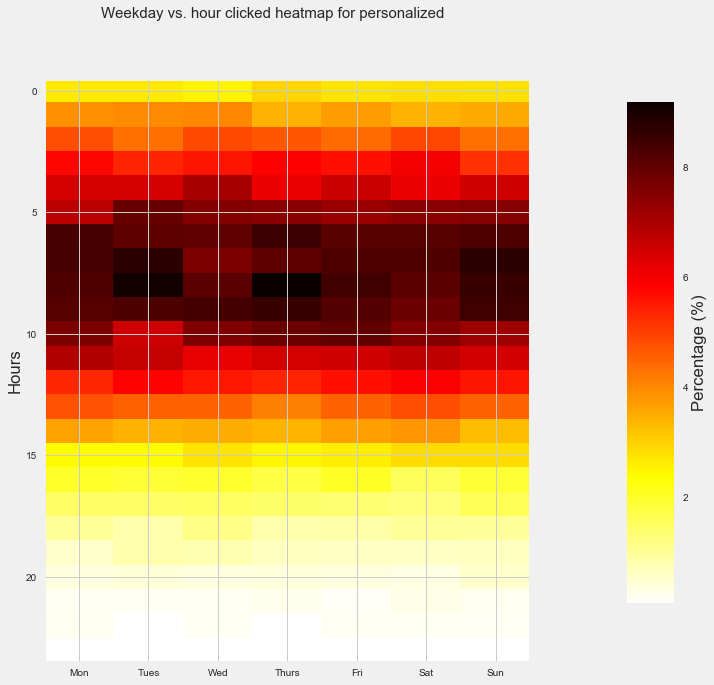

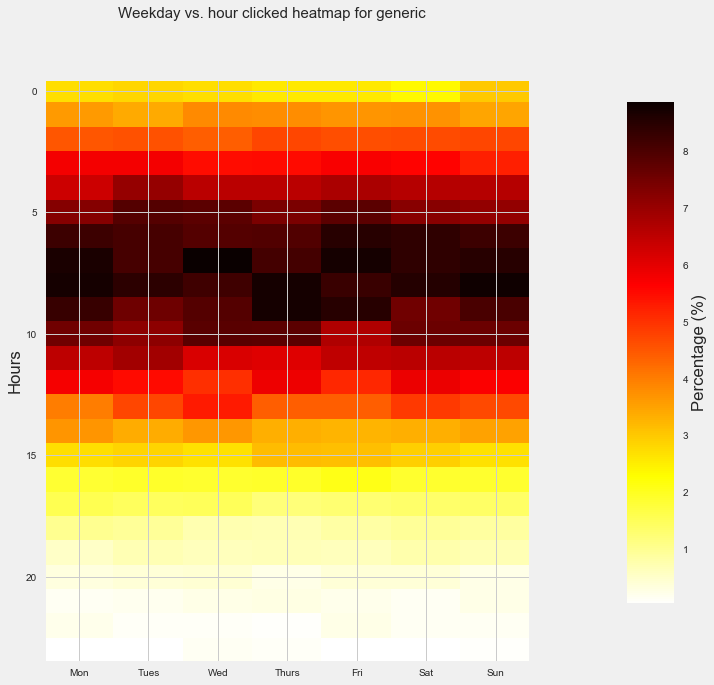

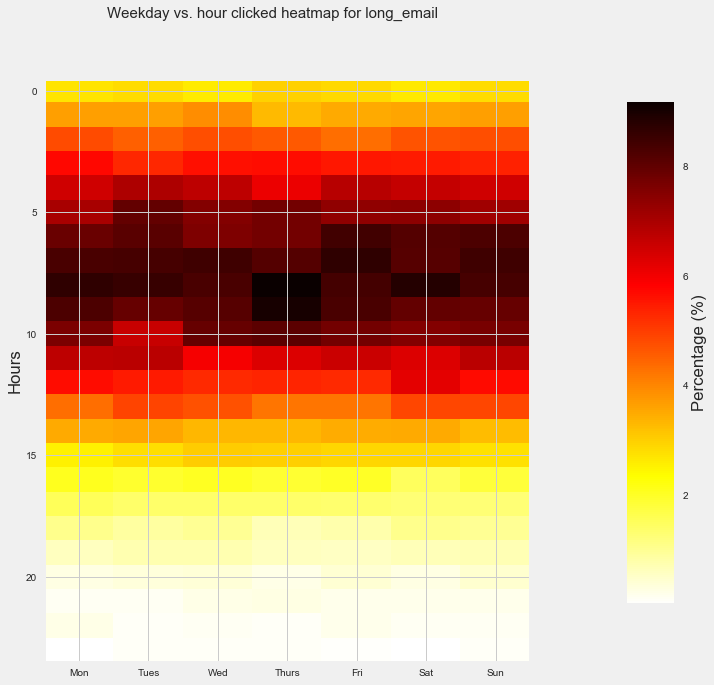

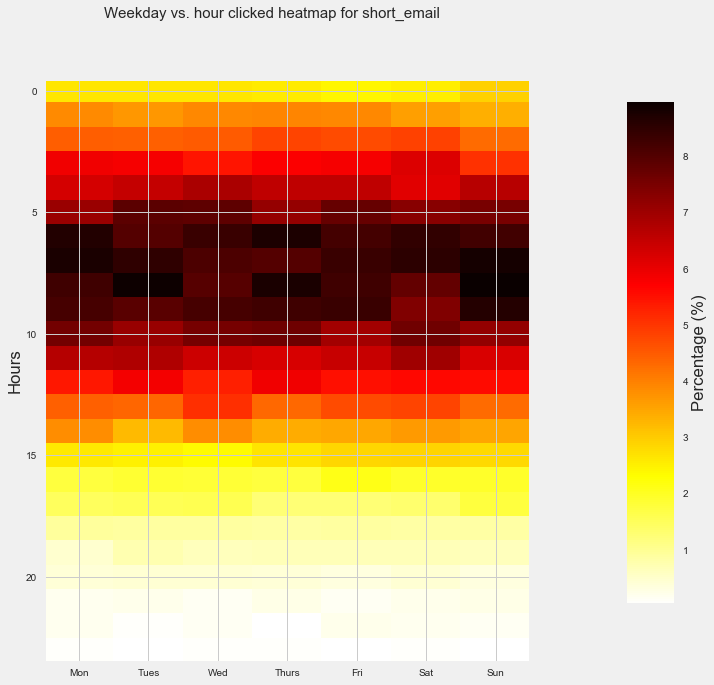

In [322]:
day_hour_heatmap(df, 'clicked', ['email_version', 'personalized'])
day_hour_heatmap(df, 'clicked', ['email_version', 'generic'])
day_hour_heatmap(df, 'clicked', ['email_text', 'long_email'])
day_hour_heatmap(df, 'clicked', ['email_text', 'short_email'])

In [331]:
# dframe = df0.copy()
# dframe = dframe.drop(['email_id', 'purchase_group'],axis=1)
# print dframe.head()
# corr_matrix = dframe.corr()
# print("Correlation matrix:")
# print(corr_matrix)
corr_matrix = df[['clicked',
 'country',
 'day_type',
#  'email_id',
 'email_text',
 'email_version',
 'hour',
 'is_personal',
 'opened',
 'paragraphs',
 'prior_purchases',
 'purchases',
#  'purchases_cat',
#  'purchases_flag',
 'response',
 'time',
 'weekday'
#     ,
#  'weekday_index'
   ]].corr()

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-20 21:27:38.098307. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


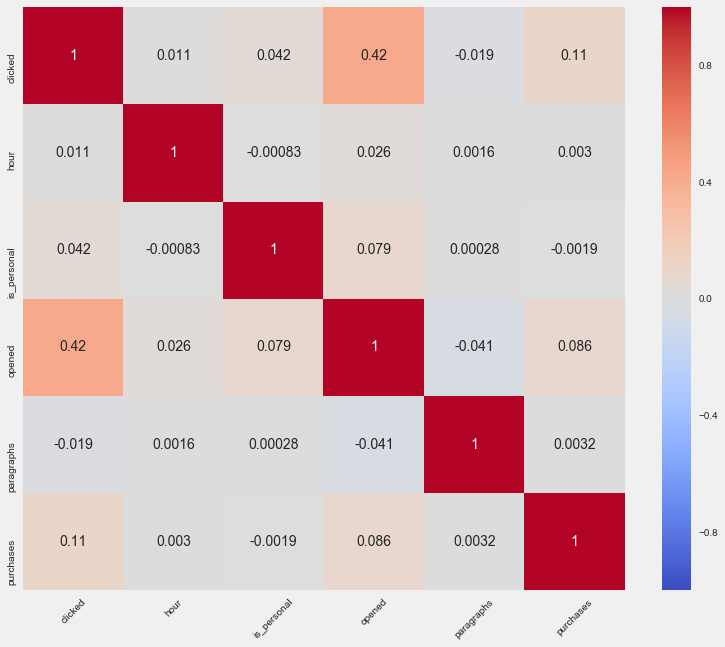

In [591]:
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix,annot=True,cbar=True,cmap="coolwarm")
plt.xticks(rotation=45)
plt.savefig('../figures/heatmap_corr.png')

Notes

Not seeing much here, only strong correlation is the one that's logical - clicks are correlated with opens, but .42 isn't super strong even so.

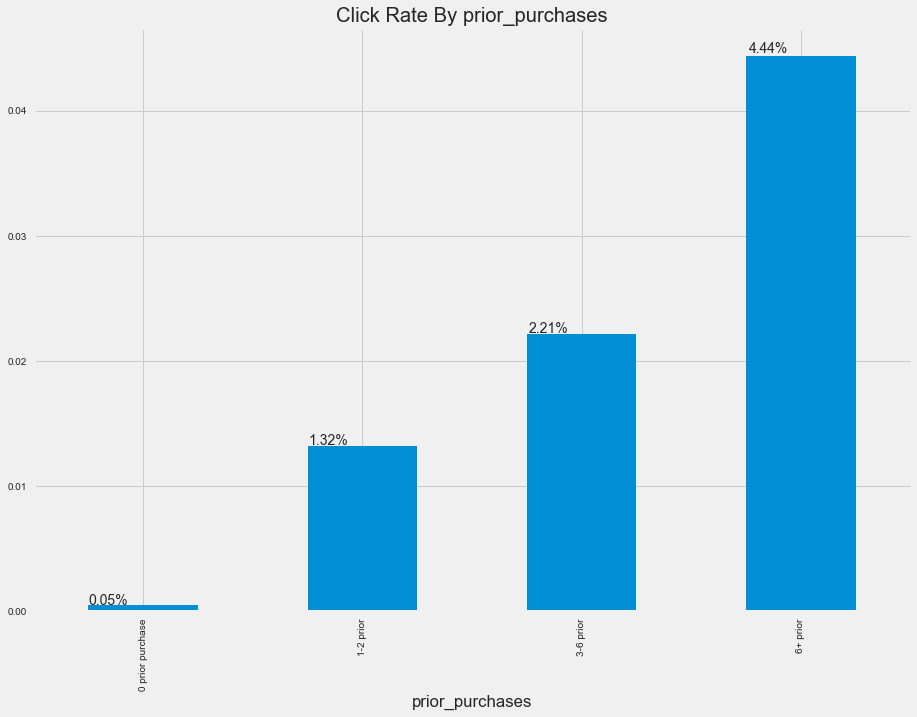

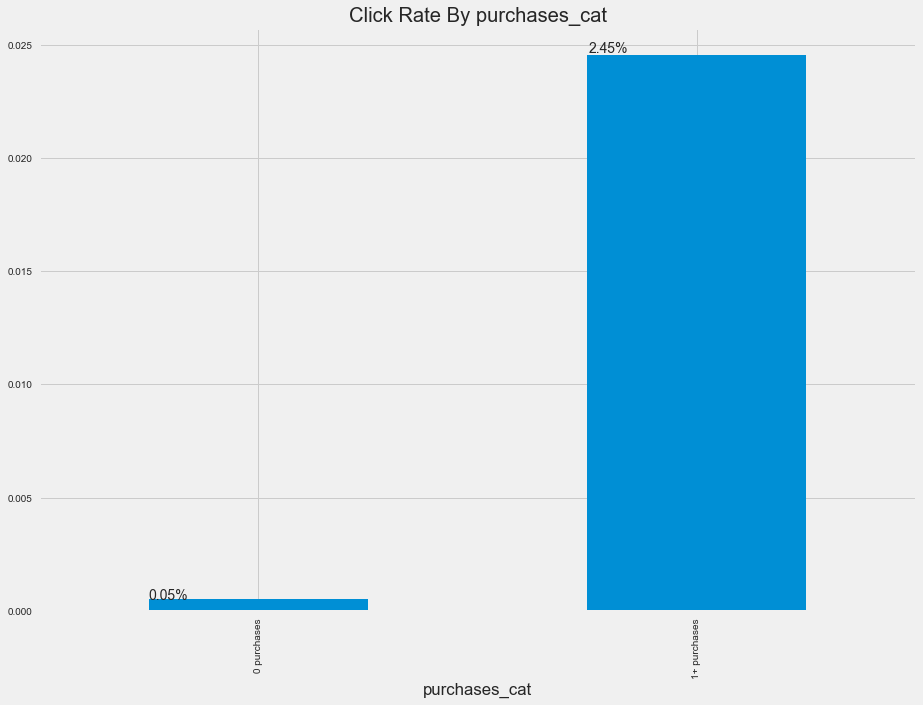

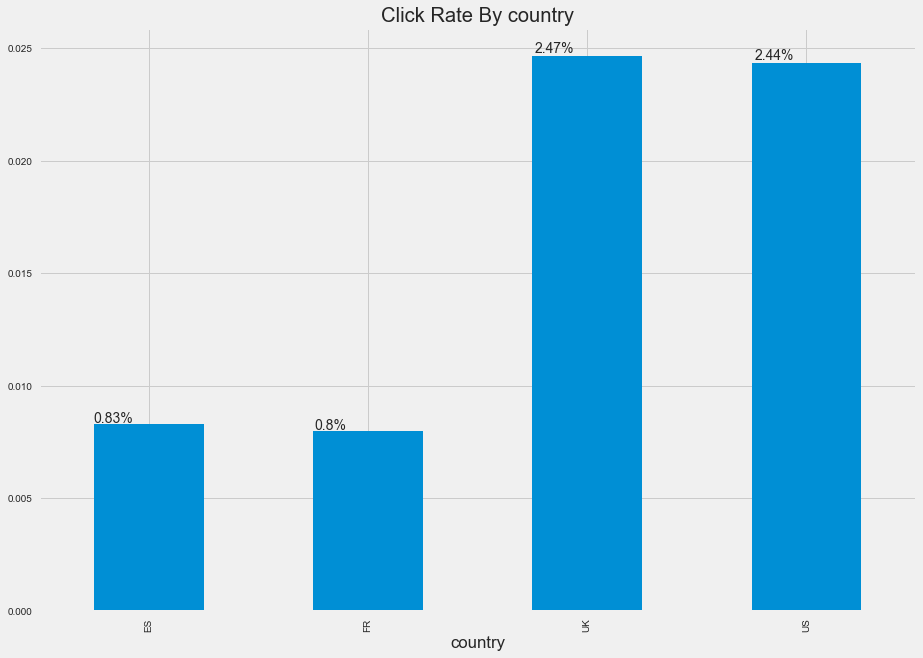

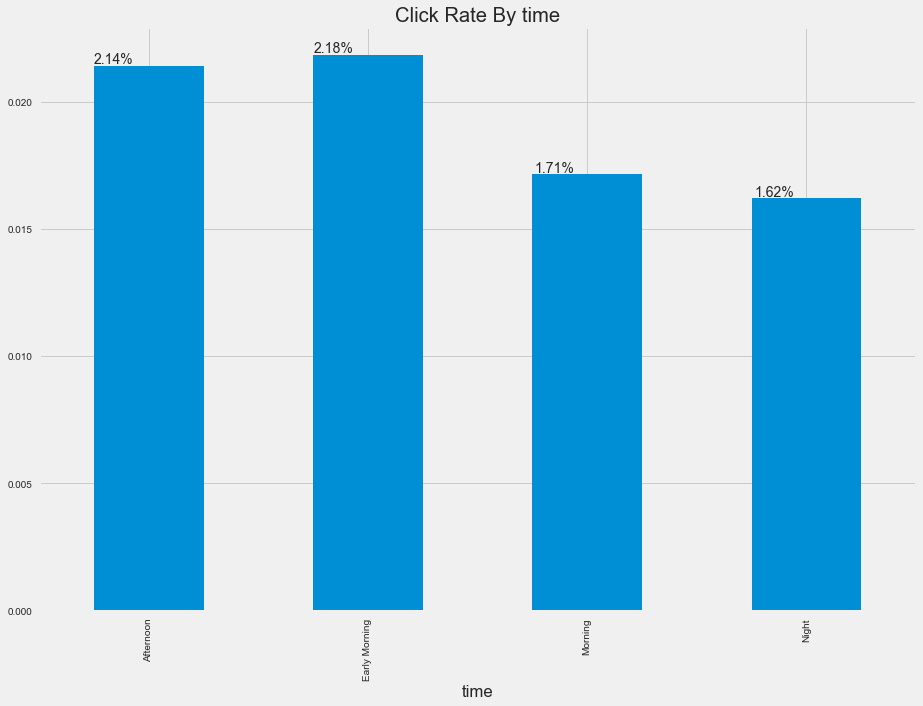

In [350]:
for var in (categorical_vars and categorical_vars2):
    ax = df.groupby(var).mean()['clicked'].plot(kind='bar',title = 'Click Rate By '+str(var))
    for p in ax.patches:
        ax.annotate(str(np.round(p.get_height()*100,2))+"%", (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.show()
    plt.savefig('../figures/click_rate_by_'+var+'.png')

In [351]:
df.head()

,email_id,email_text,email_version,hour,weekday,country,purchases,opened,clicked,response,time,prior_purchases,purchases_cat,purchases_flag,day_type,paragraphs,is_personal,weekday_index,purchase_outlier
0,85120,short_email,personalized,2,Sunday,US,5,0.0,0.0,received,Early Morning,3-6 prior,1+ purchases,1,Weekend,2,1,7,False
1,966622,long_email,personalized,12,Sunday,UK,2,1.0,1.0,clicked,Early Morning,1-2 prior,1+ purchases,1,Weekend,4,1,7,False
2,777221,long_email,personalized,11,Wednesday,US,2,0.0,0.0,received,Early Morning,1-2 prior,1+ purchases,1,Weekday,4,1,3,False
3,493711,short_email,generic,6,Monday,UK,1,0.0,0.0,received,Morning,1-2 prior,1+ purchases,1,Weekday,2,0,1,False
4,106887,long_email,generic,14,Monday,US,6,0.0,0.0,received,Afternoon,3-6 prior,1+ purchases,1,Weekday,4,0,1,False


In [352]:
dfcopy = df.copy()

In [465]:
# df = dfcopy

In [466]:
set(df)
# df_all = df[['email_id','email_text','hour','country','purchases','opened','clicked','time','prior_purchases','purchases_flag','day_type','paragraphs','is_personal','weekday_index','purchase_outlier']]
df_all = df[['email_id','email_text','hour','country','purchases','clicked','time','prior_purchases','purchases_flag','day_type','paragraphs','is_personal','weekday_index','purchase_outlier']]

In [467]:
etext = pd.get_dummies(df_all.set_index('email_id')['email_text']) 
# eversion = pd.get_dummies(df.set_index('email_id')['email_version'])  #already ahve is_personal
#remove weekday bc we already have weekday index, or remove weekday index because we have weekday. Then dumy weekday
country = pd.get_dummies(df_all.set_index('email_id')['country']) 
#remove response,
time = pd.get_dummies(df_all.set_index('email_id')['time']) 
prior_purchases = pd.get_dummies(df_all.set_index('email_id')['prior_purchases']) 
#remove purchases_cat
day_type = pd.get_dummies(df_all.set_index('email_id')['day_type']) 


In [468]:
df_all = pd.merge(df_all, etext.reset_index(), on='email_id')
df_all = pd.merge(df_all, country.reset_index(), on='email_id')
df_all = pd.merge(df_all, time.reset_index(), on='email_id')
df_all = pd.merge(df_all, prior_purchases.reset_index(), on='email_id')
df_all = pd.merge(df_all, day_type.reset_index(), on='email_id')


In [469]:
# df_all['day_type_n'] = pd.factorize(df_all['day_type'])[0]
# df_all['prior_purchases_n'] = pd.factorize(df_all['prior_purchases'])[0]
# df_all['time_n'] = pd.factorize(df_all['time'])[0]
# df_all['country_n'] = pd.factorize(df_all['country'])[0]
# df_all['etext_n'] = pd.factorize(df_all['email_text'])[0]


In [470]:
df_all.head()

,email_id,email_text,hour,country,purchases,clicked,time,prior_purchases,purchases_flag,day_type,...,Afternoon,Early Morning,Morning,Night,0 prior purchase,1-2 prior,3-6 prior,6+ prior,Weekday,Weekend
0,85120,short_email,2,US,5,0.0,Early Morning,3-6 prior,1,Weekend,...,0,1,0,0,0,0,1,0,0,1
1,966622,long_email,12,UK,2,1.0,Early Morning,1-2 prior,1,Weekend,...,0,1,0,0,0,1,0,0,0,1
2,777221,long_email,11,US,2,0.0,Early Morning,1-2 prior,1,Weekday,...,0,1,0,0,0,1,0,0,1,0
3,493711,short_email,6,UK,1,0.0,Morning,1-2 prior,1,Weekday,...,0,0,1,0,0,1,0,0,1,0
4,106887,long_email,14,US,6,0.0,Afternoon,3-6 prior,1,Weekday,...,1,0,0,0,0,0,1,0,1,0


In [471]:
df_all = df_all.drop('day_type', axis = 1)
df_all = df_all.drop('prior_purchases', axis = 1)
df_all = df_all.drop('time', axis = 1)
df_all = df_all.drop('country', axis = 1)
df_all = df_all.drop('email_text', axis = 1)

In [472]:
df_all.dtypes

email_id              int64
hour                  int64
purchases             int64
clicked             float64
purchases_flag        int64
paragraphs            int64
is_personal           int64
weekday_index         int64
purchase_outlier       bool
long_email            uint8
short_email           uint8
ES                    uint8
FR                    uint8
UK                    uint8
US                    uint8
Afternoon             uint8
Early Morning         uint8
Morning               uint8
Night                 uint8
0 prior purchase      uint8
1-2 prior             uint8
3-6 prior             uint8
6+ prior              uint8
Weekday               uint8
Weekend               uint8
dtype: object

In [473]:

cols_to_use = df_all.columns[1:]

In [474]:
print df_all['clicked'].value_counts()
print
print "Baseline"
print len(df_all[df_all['clicked']==0])*1.0*100/len(df_all)
print 100 - len(df_all[df_all['clicked']==0])*1.0*100/len(df_all)

0.0    97881
1.0     2119
Name: clicked, dtype: int64

Baseline
97.881
2.119


In [475]:
c_model = df_all[cols_to_use]
x_c = c_model.ix[:,c_model.columns != 'clicked']
y_c = df_all.ix[:,df_all.columns == 'clicked']

/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  from ipykernel import kernelapp as app
/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  app.launch_new_instance()


Building model Logistic Regression
Accuracy for Logistic Regression = 97.93
[[32318     0]
 [  682     0]]


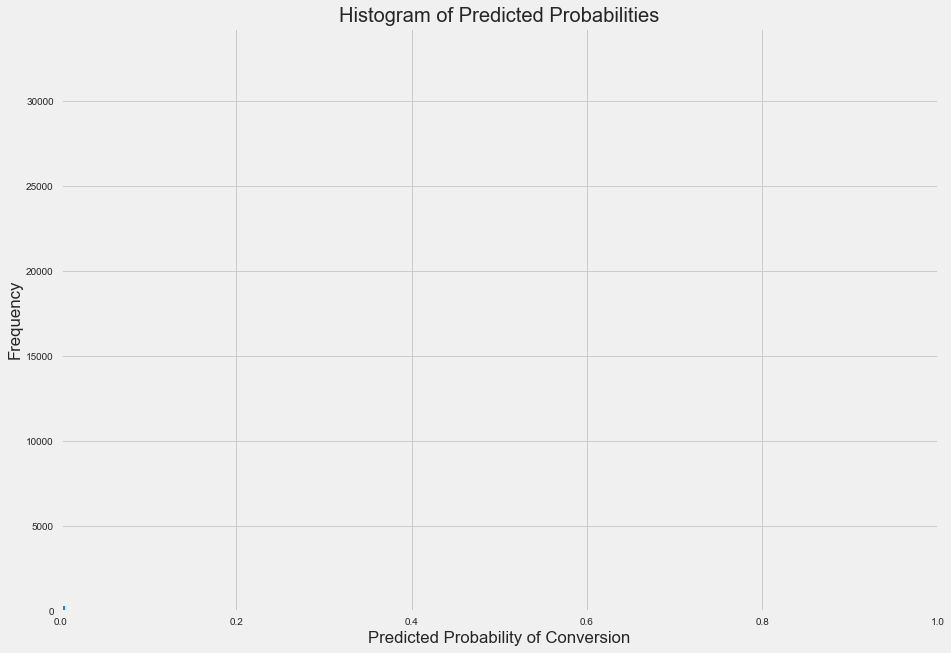

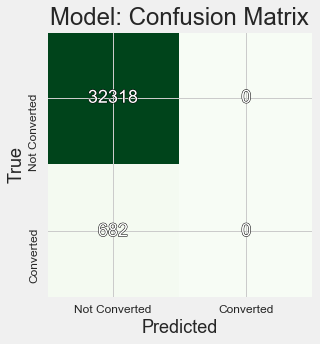

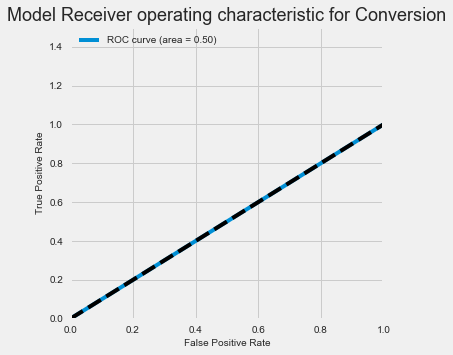

In [476]:
model_building(c_model, x_c,y_c , 'Logistic Regression')

These results are no bueno.  We're looking at a highly imbalanced dataset, but seeing these results is at least good to show that. Now we know we need to frame one way vs another.  I think I'll weigh the classifier to counter the class imbalance.  Another approach could be to downsample or upsample until you have equal class distributions.

In [477]:
# run feature selection classifier
feat_c = f_classif(x_c, y_c)
fit_c = LogisticRegression()
fit_c.fit(x_c,y_c)

# create DF to store coefficients and p-values
r2 = pd.DataFrame(data=fit_c.coef_[0],index=x_c.columns.values,columns=['coefficient'])
r2['pval'] = feat_c[1]
r2['exp_coef'] = np.exp(r2['coefficient'])
r2['sig'] = r2['pval'] <= .01

# show results
r2

,coefficient,pval,exp_coef,sig
hour,0.053882,4.766914e-04,1.055360,True
purchases,0.178684,3.908893e-245,1.195643,True
purchases_flag,0.677372,2.176634e-74,1.968698,True
paragraphs,-1.260923,4.725879e-09,0.283392,True
is_personal,0.607137,1.137670e-40,1.835169,True
weekday_index,-0.081227,5.001618e-13,0.921984,True
purchase_outlier,-0.177848,1.323256e-109,0.837070,True
long_email,0.540999,4.725879e-09,1.717722,True
short_email,-1.712460,4.725879e-09,0.180421,True
ES,-0.843447,5.506637e-21,0.430225,True


In [478]:
impcols = list(r2[r2.sig == True].reset_index()['index'].values)

In [479]:
c_model = df_all[impcols]
x_c = c_model.ix[:,c_model.columns != 'clicked']
y_c = df_all.ix[:,df_all.columns == 'clicked']


/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  from ipykernel import kernelapp as app


Building model Logistic Regression
Accuracy for Logistic Regression = 97.83
[[32283     0]
 [  717     0]]


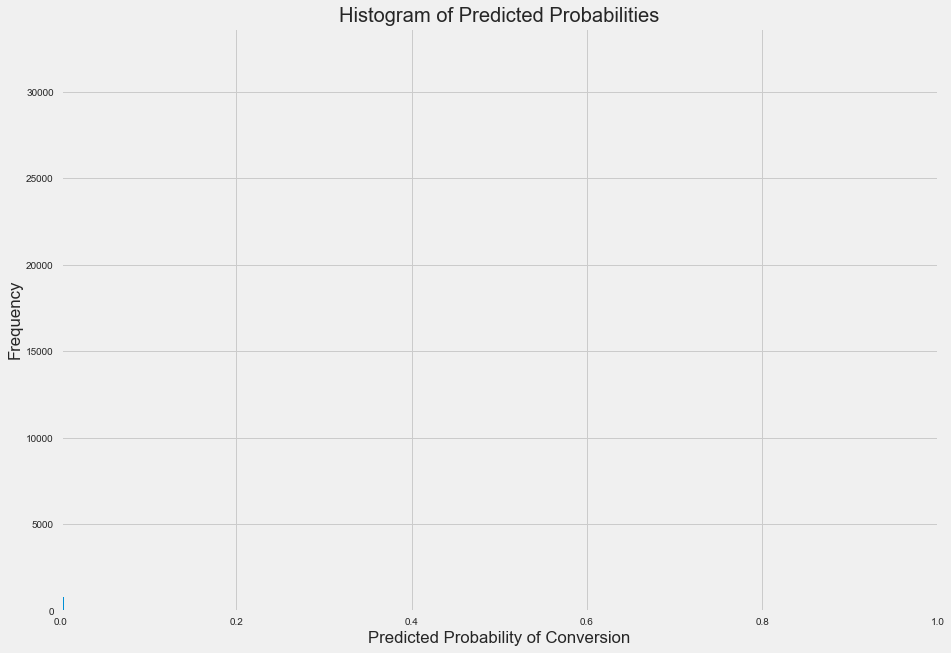

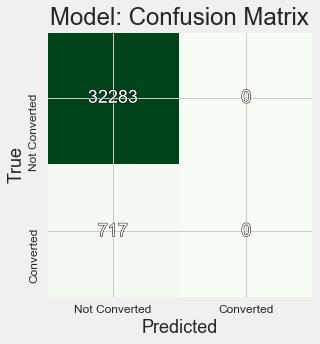

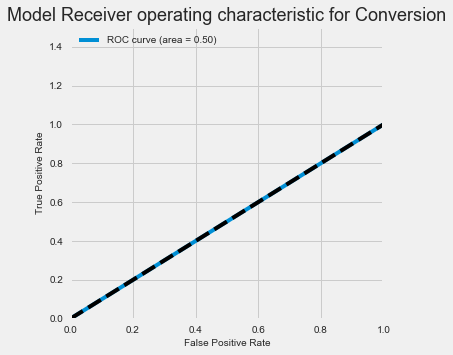

In [480]:
model_building(c_model, x_c,y_c , 'Logistic Regression')

In [481]:
# run feature selection classifier
feat_c = f_classif(x_c, y_c)
fit_c = LogisticRegression()
fit_c.fit(x_c,y_c)

# create DF to store coefficients and p-values
r2 = pd.DataFrame(data=fit_c.coef_[0],index=x_c.columns.values,columns=['coefficient'])
r2['pval'] = feat_c[1]
r2['exp_coef'] = np.exp(r2['coefficient'])
r2['sig'] = r2['pval'] <= .01

# show results
r2

,coefficient,pval,exp_coef,sig
hour,0.016554,4.766914e-04,1.016692,True
purchases,0.179175,3.908893e-245,1.196231,True
purchases_flag,0.837446,2.176634e-74,2.310459,True
paragraphs,-1.186576,4.725879e-09,0.305265,True
is_personal,0.607853,1.137670e-40,1.836483,True
weekday_index,-0.080266,5.001618e-13,0.922871,True
purchase_outlier,-0.183718,1.323256e-109,0.832171,True
long_email,0.503966,4.725879e-09,1.655274,True
short_email,-1.601221,4.725879e-09,0.201650,True
ES,-0.825992,5.506637e-21,0.437800,True


#### Random Forest
* Let's give an RF model a try. Random Forests are good because you can usually optimize the algorithm pretty quickly.  It's also pretty good with outliers, and finding important variables.  
* We're going to use the RF to predict conversion and then use it's partial dependence plots and variable feature importances to see how our model go information from the variables and which variables are the best for predicting.
* Also, we're able to build and see the tree which we can then use to find our most obvious user segments.  


#### Shuffle, Split, CV

Create test/training set with a standard 66% split (if the data were too small, I would cross-validate) and
then build the forest with standard values for the 3 most important parameters (100 trees, trees as large as
possible, 3 random variables selected at each split)

In [482]:
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import matplotlib.patheffects as path_effects
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc


def measure_performance(X, y, clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True):
    y_pred = clf.predict(X)   
    if show_accuracy:
         print "F1:{0:.3f}".format(metrics.f1_score(y, y_pred)),"\n"
    if show_classification_report:
        print "Classification report"
        print metrics.classification_report(y, y_pred),"\n"    
    if show_confusion_matrix:
        print "Confusion matrix"
        print metrics.confusion_matrix(y, y_pred),"\n"

In [483]:
print ("Baseline Accuracy: %r "%(1-df_all.clicked.mean()))

Baseline Accuracy: 0.97880999999999996 


In [484]:
c_model = df_all[impcols]
X = c_model.ix[:,c_model.columns != 'clicked']
y = df_all.iloc[:,df_all.columns == 'clicked']

/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  from ipykernel import kernelapp as app


Building model Random Forest


/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Features importance:                     values
index                     
hour              0.533251
purchases         0.203686
weekday_index     0.189779
is_personal       0.031260
UK                0.008596
US                0.004981
short_email       0.004456
long_email        0.003618
paragraphs        0.003360
FR                0.002922
ES                0.002866
6+ prior          0.002605
Weekday           0.002487
purchase_outlier  0.002452
Weekend           0.001928
1-2 prior         0.001542
0 prior purchase  0.000142
purchases_flag    0.000067
Accuracy for Random Forest = 97.66
[[32221    74]
 [  697     8]]


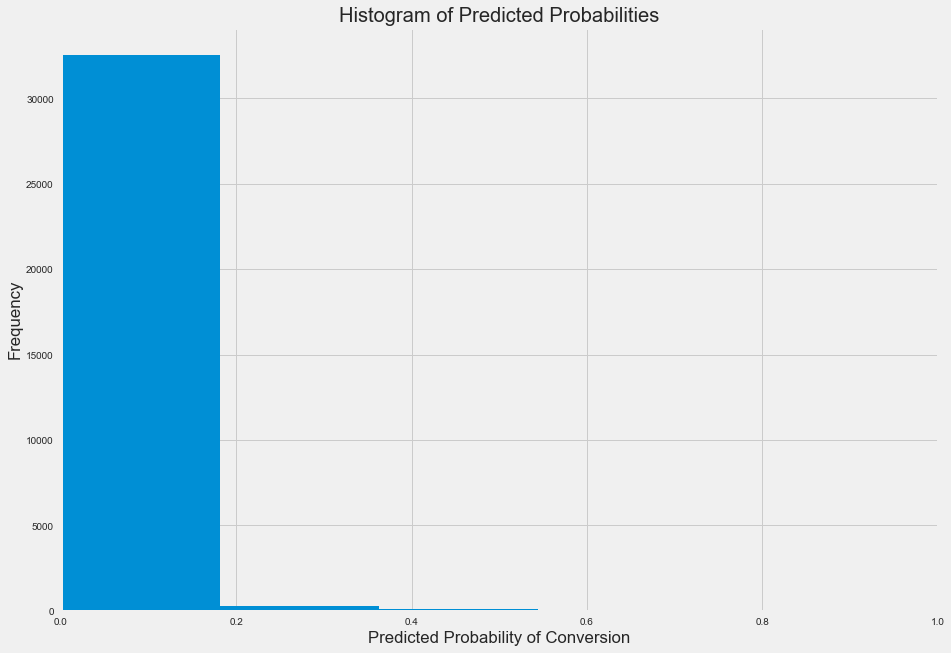

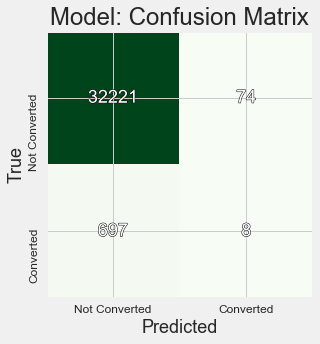

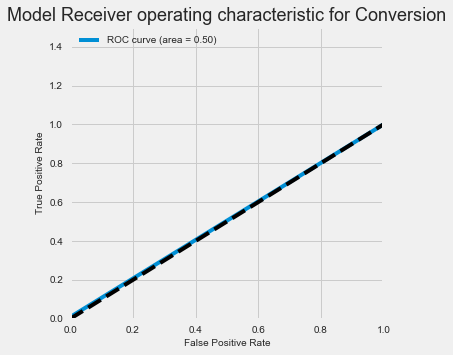

In [485]:
model_building(c_model, x_c,y_c , 'Random Forest')

In [486]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20)

In [487]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
# X_test = clf.transform(X_test)
# measure_performance(X_test_fs, y_test, clf, show_confusion_matrix=False, show_classification_report=False)
measure_performance(X_test, y_test, clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True)

/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


F1:0.020 

Classification report
             precision    recall  f1-score   support

        0.0       0.98      1.00      0.99     19594
        1.0       0.05      0.01      0.02       406

avg / total       0.96      0.98      0.97     20000


Confusion matrix
[[19502    92]
 [  401     5]] 



In [488]:
# These represent the y-intercept and coefficients for all the variables in the Random Forest.
def model_stats(model = RandomForestClassifier(), X_train = X_train, y_train = y_train, y_test = y_test, X_test = X_test):


    # 10-fold cross-validation for Random Forest to find the CV score
    mdl = model.fit(X_train, y_train)
    scores = cross_val_score(mdl, X_train, y_train, cv=10, scoring= 'accuracy')
    print("Mean CV Accuracy for Model: %r "% scores.mean())
    print()
    logit = model.predict(X_test)
    confusion = metrics.confusion_matrix(y_test, logit)
    print("Confusion Matrix for Model")
    print (confusion)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    # histogram of predicted probabilities of people leaving the company 
    plt.hist(y_pred_prob, bins=5)
    plt.xlim(0, 1)
    plt.title('Histogram of Predicted Probabilities')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    cm = confusion_matrix(y_test, logit)


    plot_confusion_matrix(cm, title='Model: Confusion Matrix', \
                          labels=['Stayed', 'Left'], cmap=plt.cm.Greens) 
    # Roc_curve for Our Model
    FPR = dict()
    TPR = dict()
    ROC_AUC = dict()

    # For class 1, find the area under the curve
    FPR[1], TPR[1], _ = roc_curve(y_test, logit)
    ROC_AUC[1] = auc(FPR[1], TPR[1])

    # Plot of a ROC curve for class 1 (Converted)
    plt.figure(figsize=[5,5])
    plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0, 1])
    plt.ylim([0, 1.5])
    plt.xlabel('False Positive Rate', fontsize=10)
    plt.ylabel('True Positive Rate', fontsize=10)
    plt.title('Model Receiver operating characteristic', fontsize=18)
    plt.legend(loc="upper left")
    plt.show()

Mean CV Accuracy for Model: 0.97442503569824268 
()
Confusion Matrix for Model
[[19500    94]
 [  400     6]]


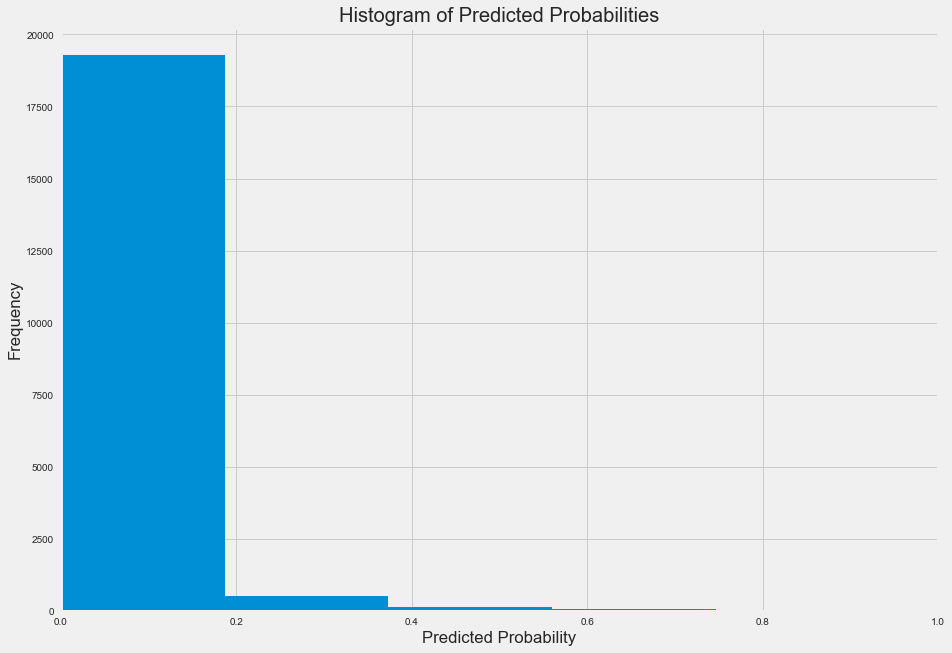

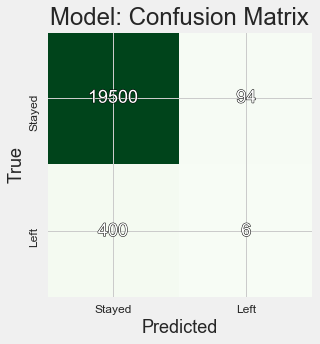

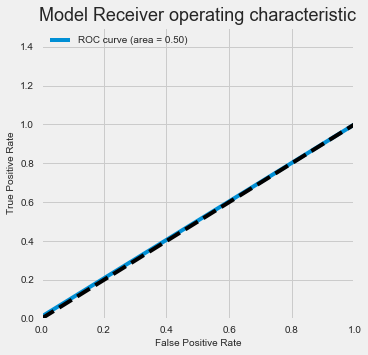

In [489]:
model_stats(model = RandomForestClassifier(), X_train = X_train, y_train = y_train.values.ravel(), y_test = y_test, X_test = X_test)

Since we started from a 98% accuracy (that’s the case if we classified everything as “non converted”), our 97% is not great

If we cared about the very best possible accuracy or specifically minimizing false positive/false negative,
we would also use ROCR and find the best cut-off point. If I had a bit more time, I'd most likely grid search and find which model gives us the best ROC curve.

Since in this case that doesn’t appear to be particularly relevant, we are fine with the default 0.5 cutoff value used internally by the random forest to make the prediction. 

Let's check out the insights we can find from this model

### Random Forest with Weighted Classes

In [490]:
clf = RandomForestClassifier(class_weight = {1:.02, 0:.98}, oob_score = True)
clf.fit(X_train, y_train)
# X_test = clf.transform(X_test)
# measure_performance(X_test_fs, y_test, clf, show_confusion_matrix=False, show_classification_report=False)
measure_performance(X_test, y_test, clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True)

/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


F1:0.029 

Classification report
             precision    recall  f1-score   support

        0.0       0.98      1.00      0.99     19594
        1.0       0.10      0.02      0.03       406

avg / total       0.96      0.98      0.97     20000


Confusion matrix
[[19529    65]
 [  399     7]] 



# Downsampling

In [491]:
# downsample negative cases -- there are many more negatives than positives
indices = np.where(df_all.clicked == 0)[0]
rng = np.random.RandomState(13)
rng.shuffle(indices)
n_pos = (df_all.clicked == 1).sum()
subdf_all = df_all.drop(df_all.index[indices[n_pos:]])

subdf_all.head()

,email_id,hour,purchases,clicked,purchases_flag,paragraphs,is_personal,weekday_index,purchase_outlier,long_email,...,Afternoon,Early Morning,Morning,Night,0 prior purchase,1-2 prior,3-6 prior,6+ prior,Weekday,Weekend
1,966622,12,2,1.0,1,4,1,7,False,1,...,0,1,0,0,0,1,0,0,0,1
3,493711,6,1,0.0,1,2,0,1,False,0,...,0,0,1,0,0,1,0,0,1,0
70,849,16,5,1.0,1,2,0,2,False,0,...,1,0,0,0,0,0,1,0,1,0
96,785407,12,2,0.0,1,2,0,4,False,0,...,0,1,0,0,0,1,0,0,1,0
115,721625,6,7,1.0,1,2,1,4,False,0,...,0,0,1,0,0,0,0,1,1,0


In [492]:
len(subdf_all)

4238

In [493]:
c_model = subdf_all[cols_to_use]
x_c = c_model.ix[:,c_model.columns != 'clicked']
y_c = subdf_all.ix[:,subdf_all.columns == 'clicked']

/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  from ipykernel import kernelapp as app
/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  app.launch_new_instance()


Building model Logistic Regression
Accuracy for Logistic Regression = 47.46
[[664   0]
 [735   0]]


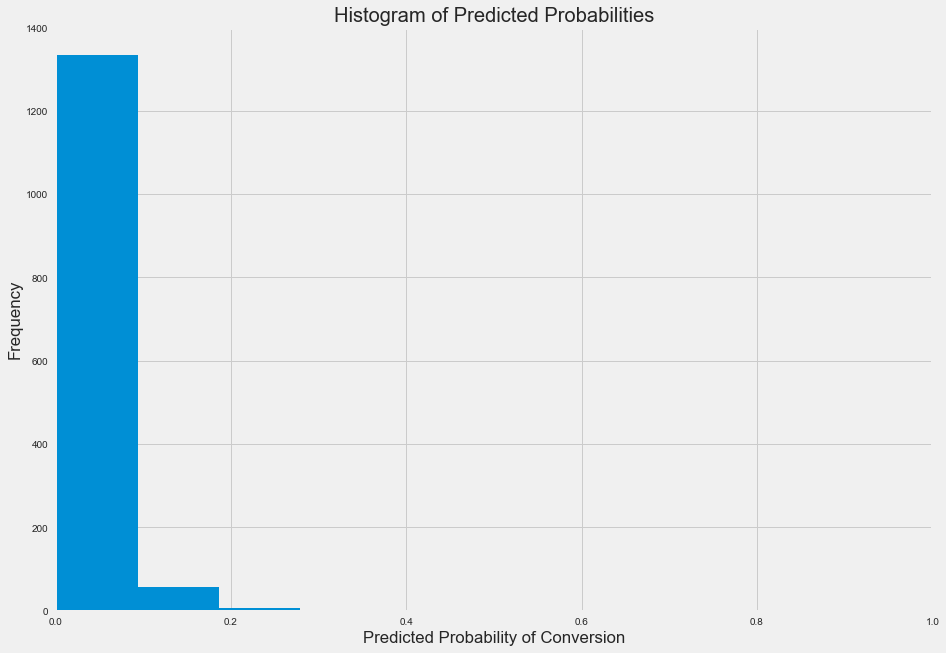

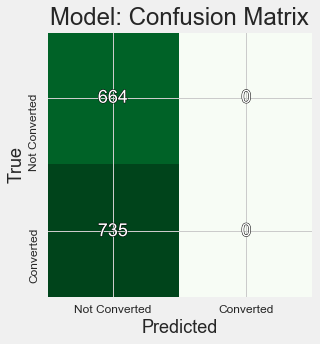

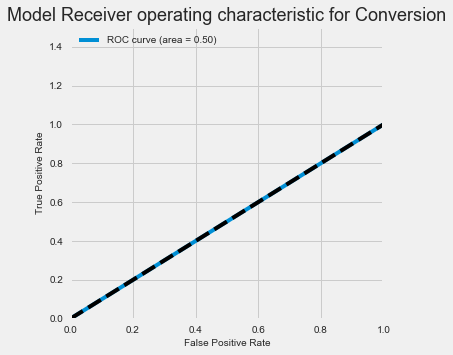

In [494]:
model_building(c_model, x_c,y_c , 'Logistic Regression')

In [495]:
# run feature selection classifier
feat_c = f_classif(x_c, y_c)
fit_c = LogisticRegression()
fit_c.fit(x_c,y_c)

# create DF to store coefficients and p-values
r2 = pd.DataFrame(data=fit_c.coef_[0],index=x_c.columns.values,columns=['coefficient'])
r2['pval'] = feat_c[1]
r2['exp_coef'] = np.exp(r2['coefficient'])
r2['sig'] = r2['pval'] <= .01

# show results
r2

,coefficient,pval,exp_coef,sig
hour,0.059442,5.931036e-02,1.061245,False
purchases,0.208359,9.567153e-115,1.231655,True
purchases_flag,0.910670,1.129780e-69,2.485988,True
paragraphs,-0.656935,1.182491e-04,0.518438,True
is_personal,0.676128,8.515555e-25,1.966249,True
weekday_index,-0.119518,1.674467e-10,0.887348,True
purchase_outlier,-0.277089,1.238106e-35,0.757987,True
long_email,0.229939,1.182491e-04,1.258523,True
short_email,-0.788346,1.182491e-04,0.454596,True
ES,-0.817186,5.297051e-21,0.441673,True


In [496]:
impcols = list(r2[r2.sig == True].reset_index()['index'].values)

In [497]:
c_model = subdf_all[impcols]
x_c = c_model.ix[:,c_model.columns != 'clicked']
y_c = subdf_all.ix[:,subdf_all.columns == 'clicked']


/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  from ipykernel import kernelapp as app


In [504]:
X = c_model.ix[:,c_model.columns != 'clicked']
y = subdf_all.iloc[:,subdf_all.columns == 'clicked']

Building model Logistic Regression
Accuracy for Logistic Regression = 48.82
[[683   0]
 [716   0]]


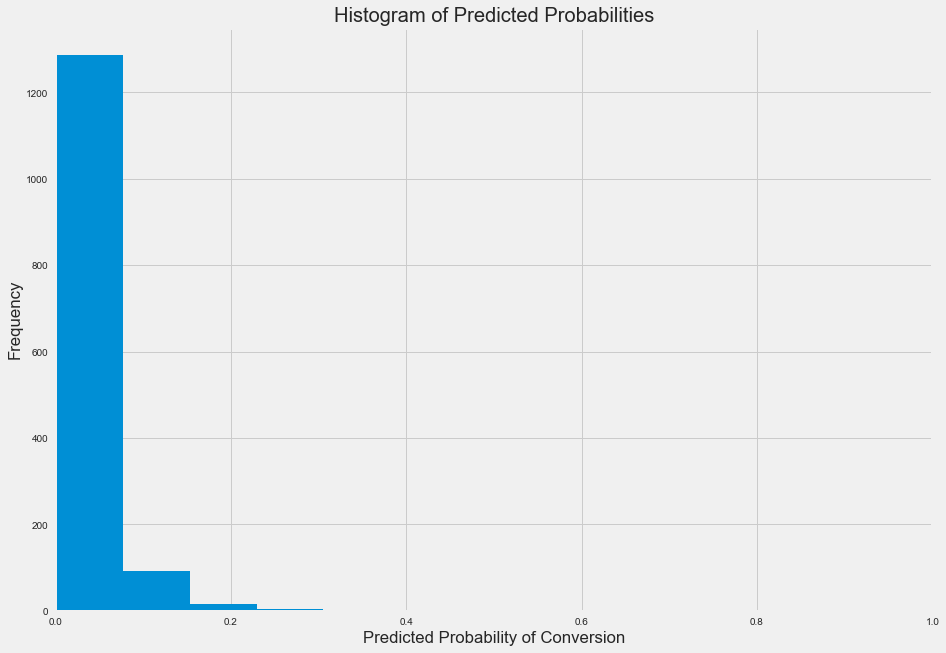

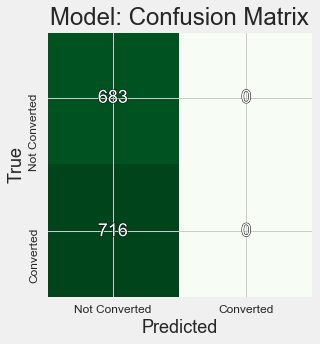

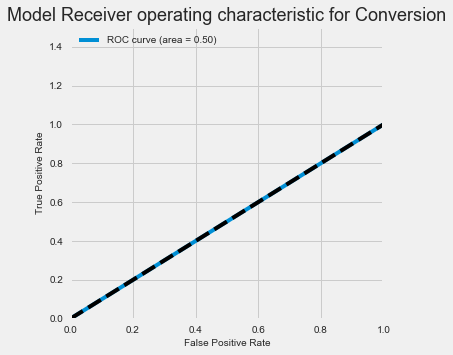

In [498]:
model_building(c_model, x_c,y_c , 'Logistic Regression')

In [499]:
# run feature selection classifier
feat_c = f_classif(x_c, y_c)
fit_c = LogisticRegression()
fit_c.fit(x_c,y_c)

# create DF to store coefficients and p-values
r2 = pd.DataFrame(data=fit_c.coef_[0],index=x_c.columns.values,columns=['coefficient'])
r2['pval'] = feat_c[1]
r2['exp_coef'] = np.exp(r2['coefficient'])
r2['sig'] = r2['pval'] <= .01

# show results
r2

,coefficient,pval,exp_coef,sig
purchases,0.210048,9.567153e-115,1.233737,True
purchases_flag,1.175727,1.129780e-69,3.240499,True
paragraphs,-0.428942,1.182491e-04,0.651198,True
is_personal,0.675221,8.515555e-25,1.964467,True
weekday_index,-0.113405,1.674467e-10,0.892789,True
purchase_outlier,-0.307362,1.238106e-35,0.735384,True
long_email,0.116093,1.182491e-04,1.123101,True
short_email,-0.446658,1.182491e-04,0.639763,True
ES,-1.281380,5.297051e-21,0.277654,True
FR,-1.185850,8.620403e-17,0.305486,True


Building model Random Forest
Features importance:                     values
index                     
weekday_index     0.343857
purchases         0.275813
Early Morning     0.092693
US                0.071172
is_personal       0.039084
ES                0.032925
Morning           0.030053
FR                0.019750
paragraphs        0.017795
purchase_outlier  0.014587
1-2 prior         0.010681
long_email        0.010595
short_email       0.009887
6+ prior          0.009670
Weekend           0.009018
Weekday           0.008959
purchases_flag    0.003272
0 prior purchase  0.000188
Accuracy for Random Forest = 58.9


/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[[520 175]
 [400 304]]


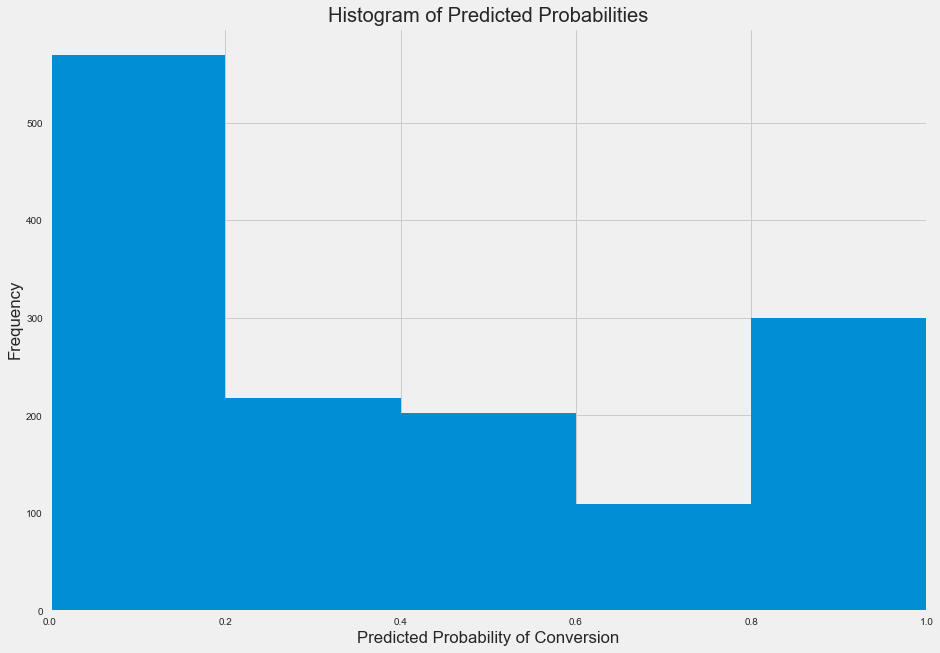

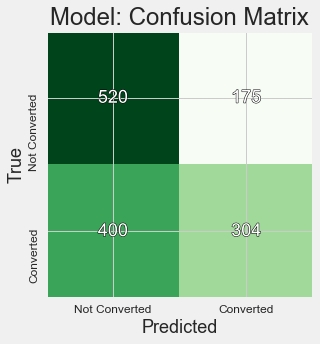

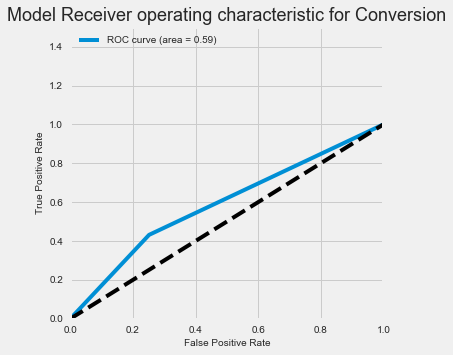

In [500]:
model_building(c_model, x_c,y_c , 'Random Forest')

In [505]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20)

In [506]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
# X_test = clf.transform(X_test)
# measure_performance(X_test_fs, y_test, clf, show_confusion_matrix=False, show_classification_report=False)
measure_performance(X_test, y_test, clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True)

F1:0.605 

Classification report
             precision    recall  f1-score   support

        0.0       0.60      0.62      0.61       417
        1.0       0.62      0.59      0.61       431

avg / total       0.61      0.61      0.61       848


Confusion matrix
[[258 159]
 [175 256]] 



/anaconda/envs/kagglehouse/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


Mean CV Accuracy for Model: 0.63243579989465548 
()
Confusion Matrix for Model
[[254 163]
 [178 253]]


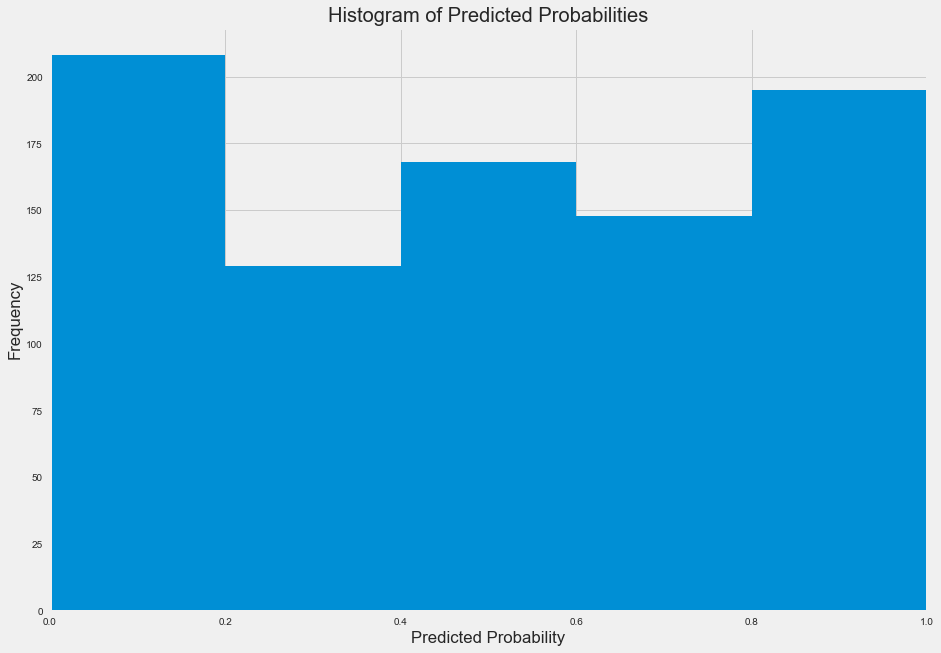

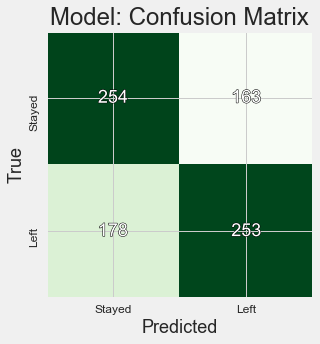

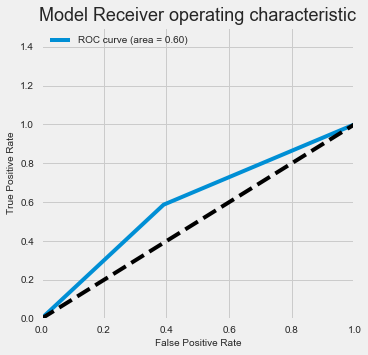

In [507]:
model_stats(model = RandomForestClassifier(), X_train = X_train, y_train = y_train.values.ravel(), y_test = y_test, X_test = X_test)

Notes - If we tune this classifer a bit more, and do some grid search we should be able to improve it's accuracy

In [512]:
# Train and tune a random forest classifer 
rf_params = {'n_estimators':[20,30,40,50],
             'criterion':['gini','entropy'],
             'max_features':['auto','log2'],
             'min_samples_leaf':[1,2,5,10,11,12,13,14,15],
             'min_samples_split':[2, 3, 5, 7,10]}
rf_clf = GridSearchCV(RandomForestClassifier(),rf_params, scoring = 'roc_auc')
rf_clf.fit(X_train,y_train.values.ravel())

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [20, 30, 40, 50], 'max_features': ['auto', 'log2'], 'min_samples_split': [2, 3, 5, 7, 10], 'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 2, 5, 10, 11, 12, 13, 14, 15]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [513]:
rf_clf.best_params_

{'criterion': 'entropy',
 'max_features': 'log2',
 'min_samples_leaf': 12,
 'min_samples_split': 2,
 'n_estimators': 20}

In [514]:
rf_clf.best_score_

0.7557692503722604

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-19 17:17:48.747475. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


Mean CV Accuracy for Model: 0.68848838797182998 
()
Confusion Matrix for Model
[[249 168]
 [129 302]]


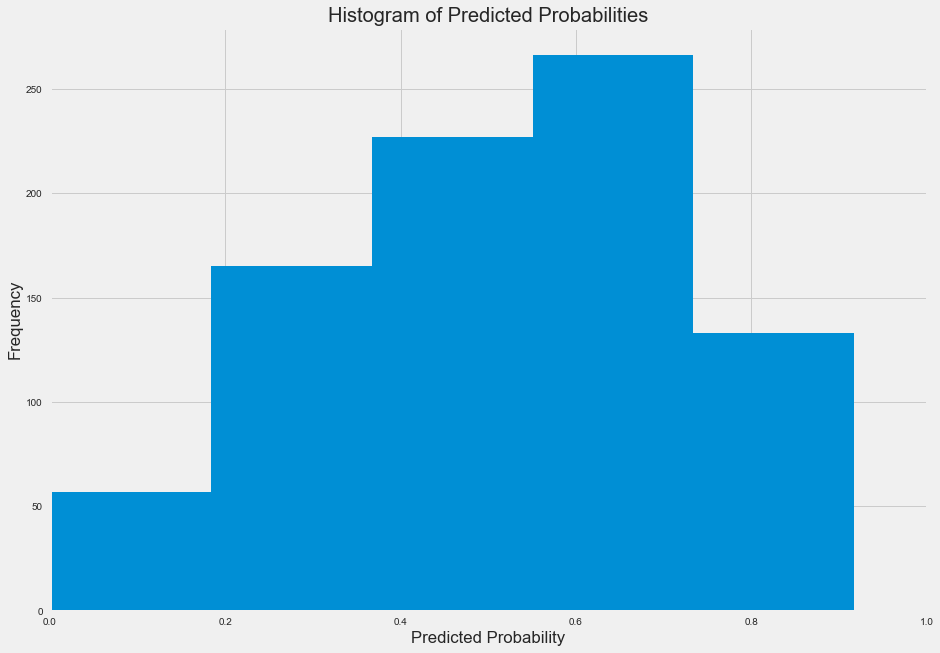

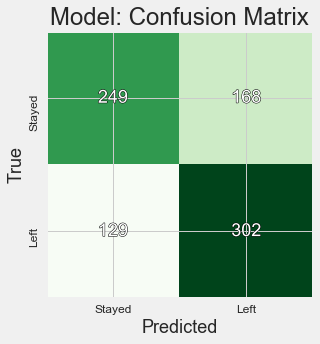

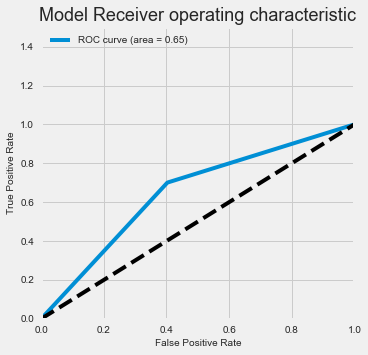

In [554]:
model_stats(model = RandomForestClassifier(criterion = 'entropy',
 max_features= 'log2',
 min_samples_leaf= 12,
 min_samples_split= 2,
 n_estimators= 20), X_train = X_train, y_train = y_train.values.ravel(), y_test = y_test, X_test = X_test)

### By how much do you think your model would improve click through rate ( defined as # of users who click on the link / total users who received the email)? How would you test that?

To test it, we need to perform a A/B test:

We'd randomly assign users to two groups, a Control group and an Experiment group.

In the control group we'll send emails the way we're doing now. But for the experiment group we'll use the model we're created.

Then we'll perform a one-tailed t-test to test whether our experiment's proportion is greater than the controls.


In [568]:
def create_optimum(df_model):
    #subset users based on optimum features
    df_optimum = df_model.copy()
    df_optimum['optimum'] = np.where((df_optimum['is_personal'] == 1) & (df_optimum['short_email'] == 1) & (df_optimum['Weekend'] == 1) & ((df_optimum['Early Morning'] == 1)), 1, 0)
    df_optimum['counter'] = 1
    df_grouped = df_optimum[['clicked', 'optimum', 'counter']].groupby('optimum').sum()
    df_grouped['ctr'] = df_grouped['clicked'] / df_grouped['counter']
    df_grouped.reset_index(inplace=True)
    return df_grouped

def calc_beta_prob(df_grouped, num_samples = 100000, target = .015):
    #perform bayesian test to simulate future data distributions
    clicks_new = df_grouped[df_grouped['optimum'] == 1]['clicked']
    view_new = df_grouped[df_grouped['optimum'] == 1]['counter']

    clicks_old = df_grouped[df_grouped['optimum'] == 0]['clicked']
    view_old = df_grouped[df_grouped['optimum'] == 0]['counter']

    new_samples = beta_dist(1 + clicks_new, 1 + view_new - clicks_new, num_samples)
    old_samples = beta_dist(1 + clicks_old, 1 + view_old - clicks_old, num_samples)

    return np.mean(new_samples - old_samples > target)

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-20 09:32:46.731623. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [581]:
#Isolate emails that meet optimum characteristics to maximize CTR
target = .02
df_grouped = create_optimum(subdf_all)
prob = calc_beta_prob(df_grouped, target=target)

#Use beta dist. to est. probability of seeing similar CTR on future samples
print "There is a {} percent chance that the optimum model would have a greater than {}% increase in the CTR.".format(prob*100,target*100)

There is a 99.419 percent chance that the optimum model would have a greater than 2.0% increase in the CTR.


//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-20 09:34:27.930215. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


### Did you ﬁnd any interesting pattern on how the email campaign performed for diﬀerent segments of users? Explain.


Collected Notes:
* We've got a US based site in which many of the users in the email list have purchased items before.
* Also many of the emails were opened in the early morning during a week day
* Those with many purchases tend to click more email links
* Makes sense as the sense of loyalty increases with each purchase and the product becomes stickier
* Those with 0 purchases basically never click the email inks
* The UK and US userbase click the email links at a much higher rate than Spain and France
* Mid day hours seem to be the best time to send an email if you want the link clicked, although the categories don't * vary too greatly in terms of click ratio
* Send an email during the week if you want to optimize for click ratio as the best day is Wednesday with a .03 ratio and the worst day is Friday with the other worst days being Sat and Sun
* Since more people click in the morning, and as we'll see CTR remains fairly evenly distributed, a suggestion would be to optimize for clicks
* Click through rate seems to be the same regardless of email length
* Personalized emails have a higher click through rate than generic emails
* Wednesday has the highest click through rate, which is aligned with what we've seen for click ratio
* If you want your email opened, send a short email as if fairs better in terms of open rate. However it's a .02 difference so that might not matter for all businesses
* Personalize your emails if you want them opened
* Send emails on Tuesday or more generally during the week if you want it opened
* While the volume of emails peak at 9, the open rate and click through rate peaks a bit later at 11. We would like to see those match up, although maybe the service provider is that slow and it takes 2 hours to deliver the email. Very unlikely but I've been in the situation where queues get backed up and emails take a while to send
* previous purchases increase the likelihood of clicking the link
* Being from US increases the likelihood of clicking the link while being from ES or FR decreases the likelihood.
* A short email decreases the likelihood of clicking the link while a long email increases it
* A personal email increases the likelihood of clicking the link greatly.
* Not having a prior purchase decreases the likelihood of clicking the link greatly
* Receiving the email in the early morning increases the likelihood whereas receiving it in the morning decreases the likelihood.


* For reference, the factors that impact the likelihood of clicking the link, with a degree of statistical significance, are below 

In [582]:
r2

//anaconda/envs/kagglehouse/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-09-20 21:17:34.686202. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


,coefficient,pval,exp_coef,sig
purchases,0.210048,9.567153e-115,1.233737,True
purchases_flag,1.175727,1.129780e-69,3.240499,True
paragraphs,-0.428942,1.182491e-04,0.651198,True
is_personal,0.675221,8.515555e-25,1.964467,True
weekday_index,-0.113405,1.674467e-10,0.892789,True
purchase_outlier,-0.307362,1.238106e-35,0.735384,True
long_email,0.116093,1.182491e-04,1.123101,True
short_email,-0.446658,1.182491e-04,0.639763,True
ES,-1.281380,5.297051e-21,0.277654,True
FR,-1.185850,8.620403e-17,0.305486,True
